In [1]:
library(data.table)
library(ggplot2)
library(dplyr)
#library(viridis)
library(qqman)
#library(qvalue)
#library(Bioconducter)
library(topGO)
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0



Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


For example usage please run: vignette('qqman')

Citation appreciated but not required:
Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The fo

__make a sites file to filter out linked loci with pcangsd__

In [233]:
#how do maf and calls across ind look- also make sites files for angsd and filter sites for pcangsd
sites <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/appc_angsd_probs.hwe.gz")
#head(sites)
unlinked <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ngsld/appc_unlinked_for_angsd.txt")
setnames(unlinked, 1:2, c("Chromo", "Position"))
unlinked[, filter := 1] #when ngsld has kept the site, mark with 1 so pcangsd knows to keep it
test_filter_sites <- left_join(sites, unlinked) #join with full sites dt and mark linked  sites with 0
#head(test_filter_sites)
#nrow(test_filter_sites)==nrow(sites) #check that this is true
test_filter_sites[is.na(filter), filter := 0]
#write out for pcangsd
#fwrite(test_filter_sites[,.(filter)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ngsld/filter_linked_sites_pcangsd.txt", col.names = F)

Joining, by = c("Chromo", "Position")

__make positions file for angsd to restrict to unlinked sites__

In [ ]:
nrow(maf[, .N, by="chromo"])
pyam <- unique(maf[chromo %like% "PYAM"], by="chromo")[, chromo] #add the PYAM sites together
names <- maf[chromo %!in% pyam, .N, by="chromo"][, "chromo"] #get a list of chromosome labels
names_with_pyam <- rbind(names, matrix(nrow=1, ncol=1, "PYAM"), use.names=F)
#fwrite(names_with_pyam, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/ngsld/chromosomes.txt", col.names =F)

__plot the pcangsd results, color by phenotypes in the association__

In [201]:
pca <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/output.pcangsd.cov")
#get eigenvalues
ev <-eigen(pca)
ev_dt <- data.table(ev$vectors[,1:10])
setnames(ev_dt, c("pc1", "pc2", "pc3", "pc4", "pc5", "pc6", "pc7", "pc8", "pc9", "pc10"))
#variance explained?
ev$values/sum(ev$values)

[1] 0.221901770 0.005986433 0.005971992 0.005970720 0.005946961 0.005897123
  [7] 0.005888754 0.005856908 0.005849885 0.005830119 0.005822542 0.005804274
 [13] 0.005774534 0.005766451 0.005756114 0.005753626 0.005750554 0.005746207
 [19] 0.005743890 0.005737366 0.005736879 0.005735947 0.005730919 0.005724538
 [25] 0.005723702 0.005720938 0.005715563 0.005705724 0.005704918 0.005700965
 [31] 0.005694457 0.005668299 0.005663375 0.005658731 0.005648217 0.005639823
 [37] 0.005620841 0.005620312 0.005613650 0.005609061 0.005590250 0.005588762
 [43] 0.005585388 0.005568958 0.005561200 0.005530672 0.005529138 0.005513271
 [49] 0.005504987 0.005497439 0.005487145 0.005462854 0.005458941 0.005447962
 [55] 0.005432130 0.005415444 0.005397950 0.005372495 0.005364970 0.005310600
 [61] 0.005283213 0.005244973 0.005230800 0.005218218 0.005190391 0.005012499
 [67] 0.004991066 0.004978531 0.004929657 0.004911353 0.004903439 0.004878348
 [73] 0.004861031 0.004853725 0.004850291 0.004838124 0.004830776 0.004825253
 [79] 0.004819311 0.004805304 0.004788511 0.004776908 0.004770615 0.004760303
 [85] 0.004755681 0.004750463 0.004741221 0.004718760 0.004717716 0.004686732
 [91] 0.004679649 0.004633633 0.004624449 0.004611324 0.004603890 0.004583634
 [97] 0.004577706 0.004573393 0.004566898 0.004560917 0.004551655 0.004535983
[103] 0.004525968 0.004517399 0.004507834 0.004499793 0.004487312 0.004461839
[109] 0.004443602 0.004441220 0.004436501 0.004433475 0.004428614 0.004425940
[115] 0.004409216 0.004407109 0.004387074 0.004372304 0.004364221 0.004348571
[121] 0.004343991 0.004340042 0.004322838 0.004315929 0.004292349 0.004289138
[127] 0.004270876 0.004268804 0.004262863 0.004256193 0.004244851 0.004238826
[133] 0.004233425 0.004232243 0.004224253 0.004220387 0.004217491 0.004209353
[139] 0.004203756 0.004198352 0.004194363 0.004186259 0.004184298 0.004182210
[145] 0.004174825 0.004169643 0.004158900 0.004130370 0.004121254 0.004115755
[151] 0.004070559 0.004042691 0.004019740 0.003952630 0.003941130 0.003912974
[157] 0.003872655 0.003807733 0.003638070

__join together the metadata with other covariates and phenotypes with the pcs- be sure to check that the samples are ordered the same as bamlist__

In [202]:
bamlist <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/bamlist.list.txt")
meta <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Sample_Meta.txt")[is.na(Group), Group :=-999][Group=="High", Group:=1][Group=="Low", Group:=0][, .(sample=gen_id, ucrit=Ucrit, sl=SL, dam, sire, case=Group, capture=Capture)]
sorted_meta <- left_join(bamlist, meta, by="sample")
pca_phenos <- cbind(sorted_meta , ev_dt)[, sequencing_lib := ifelse(capture %in% c("Pop01","Pop02","Pop03", "Pop04", "Pop05", "Pop06", "Pop07","Pop08"), 1, 2)]
#write out the pcs to use as covariates
#fwrite(pca_phenos[, "capture"], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/capture.cov", col.names = F)

Warning message in `[.data.table`(fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Sample_Meta.txt")[is.na(Group), :
“Coerced double RHS to character to match the type of the target column (column 10 named 'Group'). If the target column's type character is correct, it's best for efficiency to avoid the coercion and create the RHS as type character. To achieve that consider R's type postfix: typeof(0L) vs typeof(0), and typeof(NA) vs typeof(NA_integer_) vs typeof(NA_real_). You can wrap the RHS with as.character() to avoid this warning, but that will still perform the coercion. If the target column's type is not correct, it's best to revisit where the DT was created and fix the column type there; e.g., by using colClasses= in fread(). Otherwise, you can change the column type now by plonking a new column (of the desired type) over the top of it; e.g. DT[, `Group`:=as.double(`Group`)]. If the RHS of := has nrow(DT) elements then the assignment is called a c

In [377]:
cor.test(pca_phenos$ucrit, pca_phenos$sl)


	Pearson's product-moment correlation

data:  pca_phenos$ucrit and pca_phenos$sl
t = 0.49775, df = 145, p-value = 0.6194
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1214045  0.2018443
sample estimates:
       cor 
0.04130056 


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 3 rows containing non-finite values (stat_bin).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”Saving 6.67 x 6.67 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 3 rows containing non-finite values (stat_bin).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

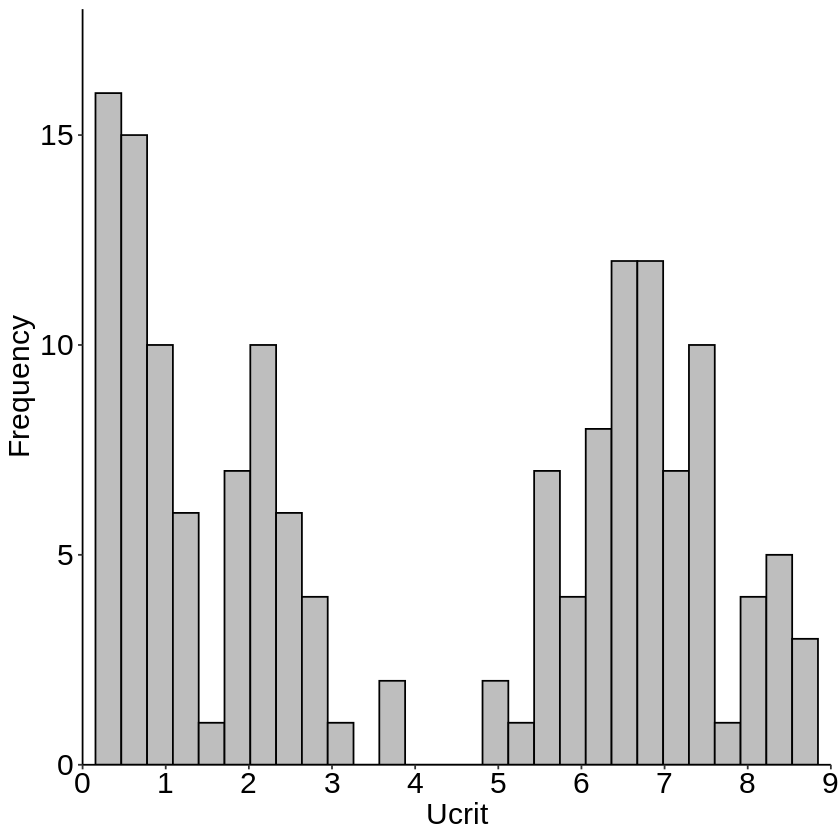

In [289]:
ucrit_fam <- ggplot()+
geom_histogram(data=pca_phenos, aes(x=ucrit), color="black", fill="gray")+
 ylab("Frequency") +
    xlab("Ucrit")+
    theme(strip.text.x = element_text(size = 14),
    legend.position = "bottom",
    legend.key=element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black"),axis.text.x =  element_text(size=18, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=18, color="black"),
    axis.title.x =  element_text(size=18, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=18, color="black"))+
    scale_x_continuous(limits = c(0,9), expand = c(0, 0), breaks=c(seq(0, 9, 1))) +    
    scale_y_continuous(expand = c(0,0), limits = c(0,18)) 

ucrit_fam
ggsave(plot=ucrit_fam, filename = "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_dist_pres.pdf")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 12 rows containing non-finite values (stat_bin).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”Saving 6.67 x 6.67 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 12 rows containing non-finite values (stat_bin).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

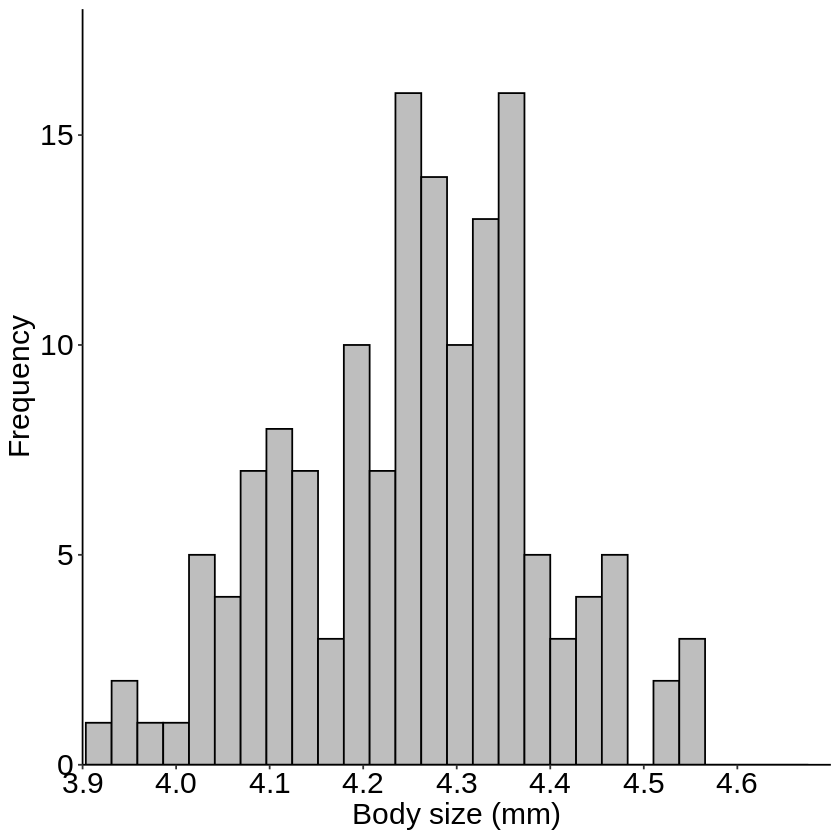

In [288]:
sl_fam <- ggplot()+
geom_histogram(data=pca_phenos, aes(x=sl), color="black", fill="gray")+
 ylab("Frequency") +
    xlab("Body size (mm)")+
    theme(strip.text.x = element_text(size = 14),
    legend.position = "bottom",
    legend.key=element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black"),axis.text.x =  element_text(size=18, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=18, color="black"),
    axis.title.x =  element_text(size=18, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=18, color="black"))+
    scale_x_continuous(limits = c(3.9,4.7), expand = c(0, 0), breaks=c(seq(3.9, 4.6, .1))) +    
    scale_y_continuous(expand = c(0,0), limits = c(0,18)) 

sl_fam
ggsave(plot=sl_fam, filename = "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_dist_pres.pdf")

In [269]:
summary(pca_phenos$sl)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  3.920   4.160   4.270   4.254   4.350   4.560      12 

In [240]:
predictors <- as.data.table(summary(glm(data=pca_phenos, ucrit ~ pc1+pc2+pc3))$coeff)
 
predictors$names <- row.names(summary(glm(data=pca_phenos, ucrit ~ pc1+pc2+pc3))$coeff)
setnames(predictors, 4, "pvalue")
predictors[pvalue <0.08][order(pvalue)]

Estimate,Std. Error,t value,pvalue,names
4.134696,0.2389598,17.30289,4.956978e-38,(Intercept)


In [265]:
summary(lm(data=pca_phenos, sl ~pc1+pc2+pc3))


Call:
lm(formula = sl ~ pc1 + pc2 + pc3, data = pca_phenos)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.37741 -0.08883  0.02049  0.09169  0.29336 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.25853    0.01065 399.963  < 2e-16 ***
pc1         -0.49653    0.13391  -3.708 0.000298 ***
pc2         -0.12181    0.13587  -0.897 0.371479    
pc3         -0.10257    0.12827  -0.800 0.425265    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1282 on 143 degrees of freedom
  (12 observations deleted due to missingness)
Multiple R-squared:  0.09615,	Adjusted R-squared:  0.07719 
F-statistic: 5.071 on 3 and 143 DF,  p-value: 0.002291


In [261]:
#what pcs/covariates explain the phenotype?
predictors <- as.data.table(summary(glm(data=pca_phenos, sl ~pc1+pc2+pc3))$coeff)
 
predictors$names <- row.names(summary(glm(data=pca_phenos, sl ~ pc1+pc2+pc3))$coeff)
setnames(predictors, 4, "pvalue")
predictors[pvalue <0.06][order(pvalue)]

Estimate,Std. Error,t value,pvalue,names
4.2585276,0.01064732,399.962566,6.512067e-220,(Intercept)
-0.4965271,0.13391083,-3.707894,2.982073e-04,pc1


In [248]:
library(broom)

In [255]:
summary(glm(data=pca_phenos, sl ~pc1+pc2+pc3))
sl_results <- tidy(glm(data=pca_phenos, sl ~pc1+pc2+pc3))
fwrite(sl_results, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_pca_glm.csv" )
ucrit_results <- tidy(glm(data=pca_phenos, ucrit ~pc1+pc2+pc3))
fwrite(ucrit_results, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_pca_glm.csv" )



Call:
glm(formula = sl ~ pc1 + pc2 + pc3, data = pca_phenos)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.37741  -0.08883   0.02049   0.09169   0.29336  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.25853    0.01065 399.963  < 2e-16 ***
pc1         -0.49653    0.13391  -3.708 0.000298 ***
pc2         -0.12181    0.13587  -0.897 0.371479    
pc3         -0.10257    0.12827  -0.800 0.425265    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.01643846)

    Null deviance: 2.6008  on 146  degrees of freedom
Residual deviance: 2.3507  on 143  degrees of freedom
  (12 observations deleted due to missingness)
AIC: -180.78

Number of Fisher Scoring iterations: 2


In [ ]:
#fwrite(pca_phenos[,.(pc1, pc2, pc3)],"/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/pc1-3_unlinked.cov", col.names = FALSE )

In [232]:
str(pca_phenos)

ERROR: Error in str(pca_phenos): object 'pca_phenos' not found


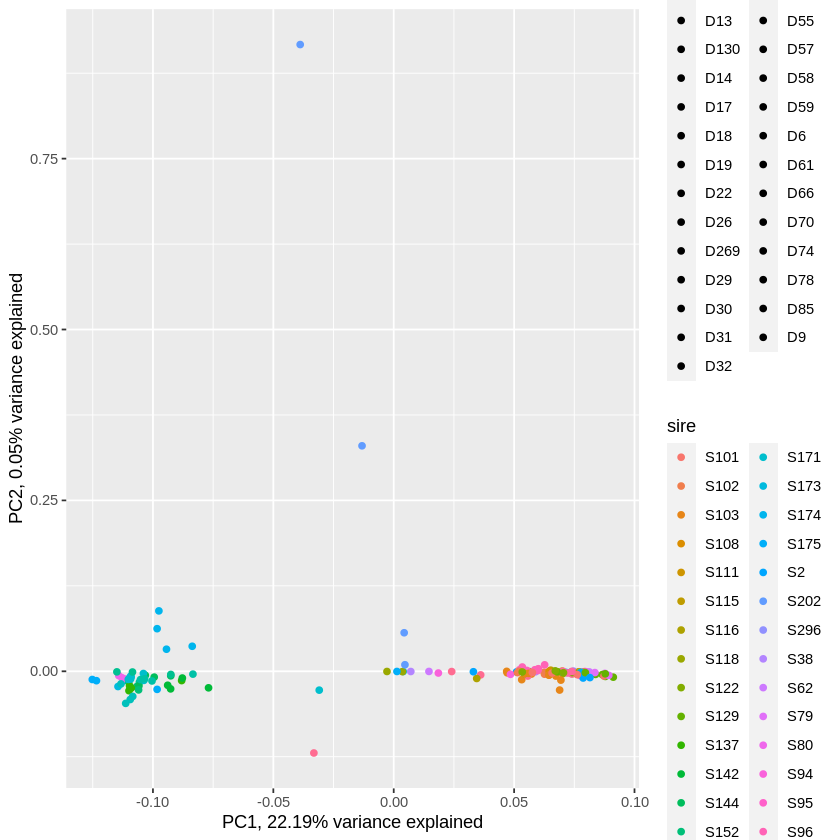

In [254]:
pca_plot <- ggplot(data=pca_phenos, aes(x=pc1, y=pc2, color=sire))+
    geom_point()+
    xlab("PC1, 22.19% variance explained")+
    ylab("PC2, 0.05% variance explained")
pca_plot

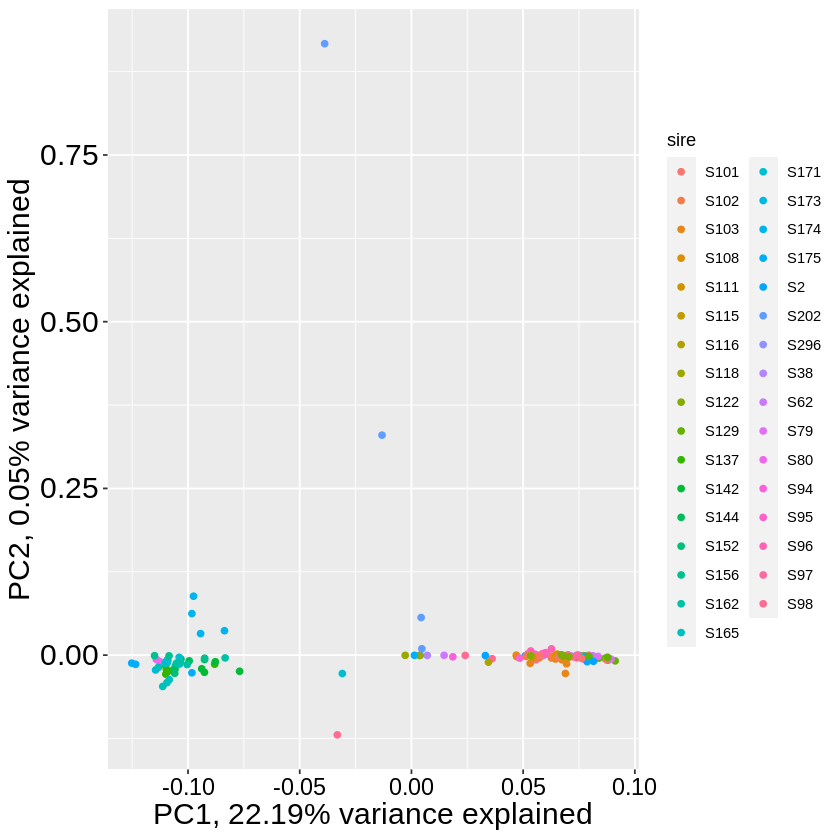

In [252]:
pca_plot <- ggplot(data=pca_phenos, aes(x=pc1, y=pc2, color=sire))+
    geom_point()+
    xlab("PC1, 22.19% variance explained")+
    ylab("PC2, 0.05% variance explained") +
    theme(strip.text.x = element_text(size = 14),
    axis.text.x =  element_text(size=14, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=18, color="black"),
    axis.title.x =  element_text(size=18, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=18, color="black"))
pca_plot

In [253]:
ggsave(plot=pca_plot, filename = "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/pca_sire_color_pres.pdf")

Saving 6.67 x 6.67 in image


In [ ]:
#ggplot()+
#    geom_point(data=pca_phenos[], aes(x=pc1, y=pc2, col=sl)) +
#    scale_color_viridis(color.palette=magma)

In [ ]:
#ggplot()+
#    geom_point(data=pca_phenos, aes(x=pc1, y=pc2, col=ucrit)) +
#    scale_color_viridis(option="magma")

In [ ]:
#ggplot()+
#    geom_point(data=pca_phenos, aes(x=pc1, y=pc2, col=sequencing_lib)) +
#    scale_color_viridis(option="magma")

In [ ]:
ggplot(data=pca_phenos, aes(x=pc1, y=pc2, col=dam, label=sample))+
    geom_point() #+
    #geom_text(nudge_x = 0.02)

### evaluate model and plot GWAS results for each phenotype

In [5]:
lrt_ucrit <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/ucrit_assoc5_maf0.05_noMaxdepth_minQ30_minCount16.lrt0.gz")
lrt_ucrit[, locus := paste(Chromosome, Position, sep=":")]
setnames(lrt_ucrit, "LRTscore", "LRT")

#filter out loci in hwe and NAN
lrt_filt_ucrit <- lrt_ucrit[LRT>0][Chromosome %in% as.character(seq(1,24,1))][, Chromosome := paste0("chr", Chromosome, sep="")] 
#format for manhattan plot
#get pvalues
lrt_filt_ucrit$pvalue<-pchisq(lrt_filt_ucrit$LRT, df=1, lower=F)
#lrt_filt_ucrit[, Chromosome := gsub("CM","", Chromosome, fixed = T)][, Chromosome := gsub("PYAM","", Chromosome, fixed = T)]#[, Chromosome := gsub(".","", Chromosome, fixed = T)]
#lrt_filt_ucrit[, Chromosome := as.numeric(Chromosome)]
lrt_filt_ucrit$SNP<-paste("r",1:length(lrt_filt_ucrit$Chromosome), sep="")


In [13]:
summary(lrt_filt_ucrit)

  Chromosome           Position           Major              Minor          
 Length:132100      Min.   :     991   Length:132100      Length:132100     
 Class :character   1st Qu.: 8227103   Class :character   Class :character  
 Mode  :character   Median :19695074   Mode  :character   Mode  :character  
                    Mean   :19899771                                        
                    3rd Qu.:30900435                                        
                    Max.   :46122757                                        
                                                                            
   Frequency             N            LRT            high_WT/HE/HO     
 Min.   :0.05034   Min.   :159   Min.   : 0.000001   Length:132100     
 1st Qu.:0.14459   1st Qu.:159   1st Qu.: 0.074907   Class :character  
 Median :0.22166   Median :159   Median : 0.335976   Mode  :character  
 Mean   :0.21649   Mean   :159   Mean   : 0.743430                     
 3rd Qu.:0.27479   3rd Q

In [7]:
lrt_sl <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/sl_assoc5_maf0.05_noMaxdepth_unlinkedPC1cov_minQ30_minCount16.lrt0.gz")
lrt_sl[, locus := paste(Chromosome, Position, sep=":")]
#for hybrid assoc 5
#setnames(lrt_sl, "LRTscore", "LRT")
#filter out loci in hwe and NAN
lrt_filt_sl <- lrt_sl[LRT>0][Chromosome %in% as.character(seq(1,24,1))][, Chromosome := paste0("chr", Chromosome, sep="")] 
#lrt_filt <- lrt[LRT>0]
#format for manhattan plot
#get pvalues
lrt_filt_sl$pvalue<-pchisq(lrt_filt_sl$LRT, df=1, lower=F)
#lrt_filt_sl[, Chromosome := gsub(".","", Chromosome, fixed = T)][, Chromosome := gsub("CM","", Chromosome, fixed = T)][, Chromosome := gsub("PYAM","", Chromosome, fixed = T)]
#lrt_filt_sl[, Chromosome := as.numeric(Chromosome)]
lrt_filt_sl$SNP<-paste("r",1:length(lrt_filt_sl$Chromosome), sep="")



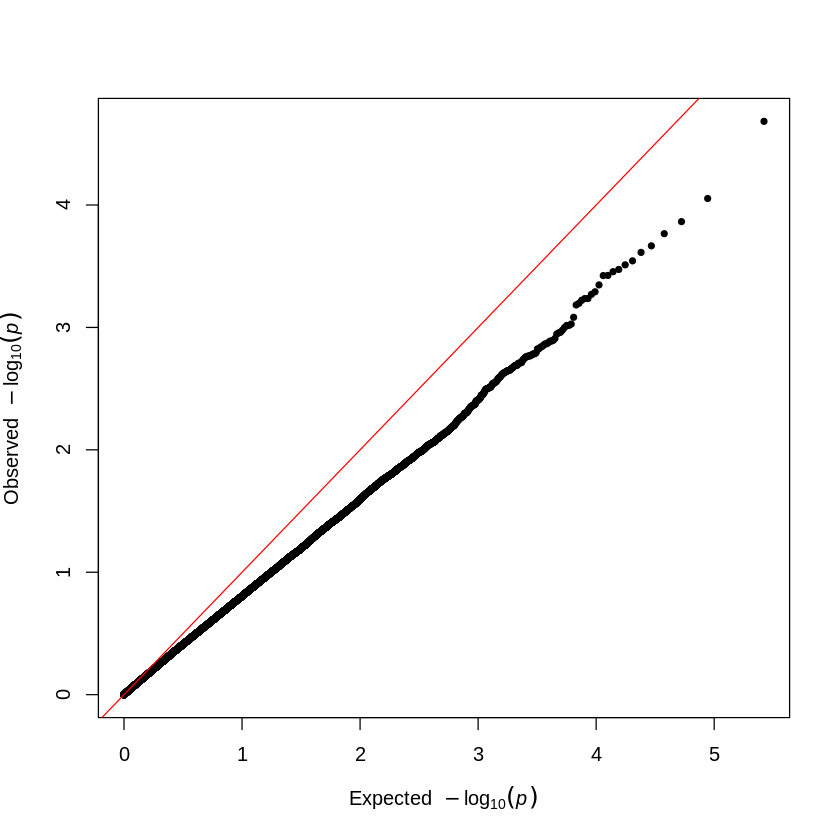

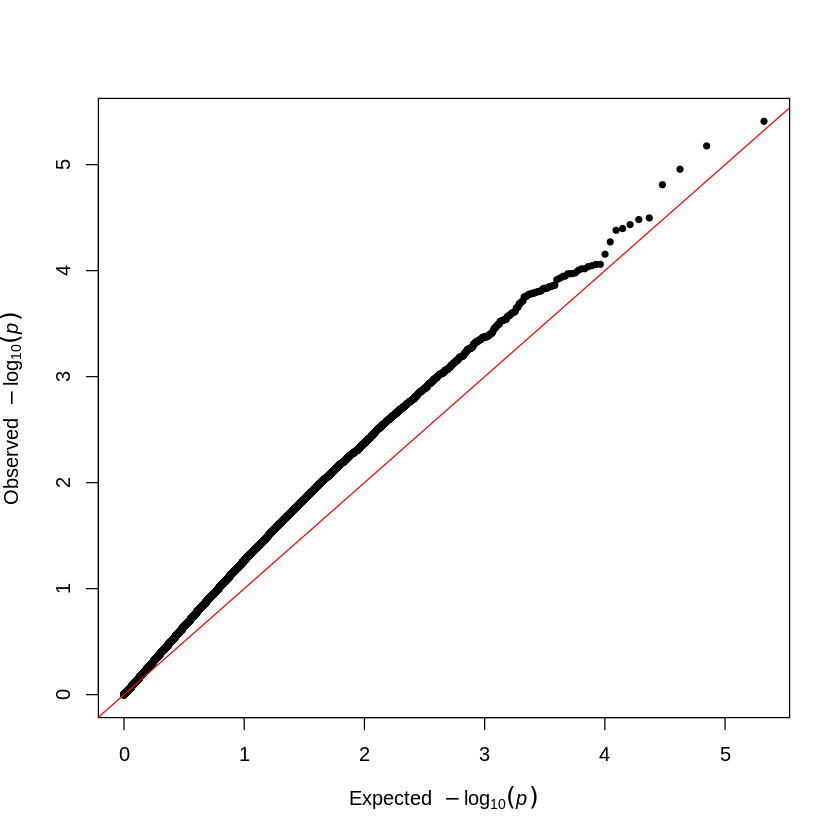

In [8]:
#pdf("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/pval_qq_ucrit.pdf")
qqman::qq(lrt_filt_ucrit$pvalue)
#dev.off()

#pdf("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/pval_qq_sl.pdf")
qqman::qq(lrt_filt_sl$pvalue)
#dev.off()


In [202]:
#png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/pval_qq_ucrit.png")
qqman::qq(lrt_filt_ucrit$pvalue)
#dev.off()

#png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/pval_qq_sl.png")
qqman::qq(lrt_filt_sl$pvalue)
#dev.off()


png 
  2

png 
  2

In [157]:
#compare plots and inflation 
#pdf("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/lrt_qq_ucrit.pdf")
qqplot(lrt_filt_ucrit$exp_lrt, lrt_filt_ucrit$LRT, xlab = "Expected LRT", ylab="Observed LRT")
abline(0, 1, col = "red")
#dev.off()
#median(lrt_filt_ucrit$LRT) / median(lrt_filt_ucrit$exp_lrt) #GC lambda = ratio at medians
#summary(lrt_filt_ucrit$LRT)

#pdf("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/lrt_qq_sl.pdf")
qqplot(lrt_filt_sl$exp_lrt, lrt_filt_sl$LRT, xlab = "Expected LRT", ylab="Observed LRT")
abline(0, 1, col = "red")
#dev.off()
#median(lrt_filt_sl$LRT) / median(lrt_filt_sl$exp_lrt) #GC lambda = ratio at medians
#summary(lrt_filt_sl$LRT)


png 
  2

png 
  2

__Stricter pvalue cutoff from Malin__

In [20]:
ucrit_files <- list.files(path = "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/permute/assoc2/", pattern = glob2rx("^ucrit*.lrt0"))

null_int <- as.data.frame(matrix(nrow=0, ncol=3))
setDT(null_int)
setnames(null_int, c("Chromosome", "min_pvalue", "iteration"))

for(i in 1:length(ucrit_files)){
    null <- fread(paste("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/permute/assoc2/", ucrit_files[i], sep=""))[LRT >0 & Chromosome <=24][, pvalue:=pchisq(LRT, df=1, lower=F)]
    null_int <- rbind(null_int, null[,.(min_pvalue=min(pvalue)), by="Chromosome"][, iteration := i])
}
ucrit_null_chrom <- null_int
ucrit_null_chrom_lowest <- ucrit_null_chrom[, .(lower.25=quantile(min_pvalue, .025)[[1]]), by=Chromosome][,Chromosome:=paste0("chr", Chromosome, sep="")]
ucrit_null.25 <- left_join(ucrit_null_chrom_lowest, lrt_filt_ucrit[Chromosome %like%"chr"])[pvalue <=lower.25]
ucrit_null.25

Joining, by = "Chromosome"

Chromosome,lower.25,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,SE,emIter,locus,pvalue,SNP
chr24,5.322387e-05,6021620,T,C,0.13961,159,18.12104,33/13/0,19.33754,-3.541276,1.039912,21,24:6021620,2.072977e-05,r129188


In [21]:
head(null_int)

Chromosome,min_pvalue,iteration
1,6.603285e-05,1
2,1.250076e-04,1
10,3.633106e-04,1
11,9.306148e-05,1
12,5.301038e-04,1
13,5.703414e-04,1


In [24]:
2.072977e-05<1.74241e-05

[1] FALSE

In [22]:
ucrit_null_chrom[, .(lower.25=quantile(min_pvalue, .025)[[1]])]

lower.25
1.74241e-05


In [8]:
ucrit_null_chrom_lowest <- ucrit_null_chrom[, .(lower.2=quantile(min_pvalue, .2)[[1]]), by=Chromosome][,Chromosome:=paste0("chr", Chromosome, sep="")]
ucrit_null.2 <- left_join(ucrit_null_chrom_lowest, lrt_filt_ucrit[Chromosome %like%"chr"])[pvalue <=lower.2]
ucrit_null.2

Joining, by = "Chromosome"

Chromosome,lower.2,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,SE,emIter,locus,pvalue,SNP
chr13,8.740379e-05,34982957,A,T,0.143409,159,14.54706,30/10/0,15.54311,-3.400393,1.096761,28,13:34982957,7.255504e-05,r75803
chr24,9.140866e-05,6021620,T,C,0.139610,159,18.12104,33/13/0,19.33754,-3.541276,1.039912,21,24:6021620,1.088639e-05,r129188


In [25]:
sl_files <- list.files(path = "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/permute/assoc2/", pattern = glob2rx("^sl*.lrt0.gz"))

null_int <- as.data.frame(matrix(nrow=0, ncol=3))
setDT(null_int)
setnames(null_int, c("Chromosome", "min_pvalue", "iteration"))

for(i in 1:length(sl_files)){
    null <- fread(paste("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/permute/assoc2/", sl_files[i], sep=""))[LRT >0 & Chromosome <=24][, pvalue:=dchisq(LRT, df=1)]
    null_int <- rbind(null_int, null[,.(min_pvalue=min(pvalue)), by="Chromosome"][, iteration := i])
}
sl_null_chrom <- null_int
sl_null_chrom_lowest <- sl_null_chrom[, .(lower.25=quantile(min_pvalue, .025)[[1]]), by=Chromosome][,Chromosome:=paste0("chr", Chromosome, sep="")]
sl_null.25 <- left_join(sl_null_chrom_lowest, lrt_filt_sl[Chromosome %like%"chr"])[pvalue <=lower.25]
sl_null.25

Joining, by = "Chromosome"

Chromosome,lower.25,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,locus,pvalue,SNP
chr11,7.294568e-06,7825612,T,G,0.206307,147,21.31278,24/11/0,11:7825612,3.901212e-06,r50869
chr24,1.585924e-05,16962690,T,G,0.258409,147,20.29089,10/13/0,24:16962690,6.651661e-06,r104351


In [26]:
sl_null_chrom[, .(lower.25=quantile(min_pvalue, .025)[[1]])]

lower.25
7.336669e-06


In [10]:
sl_null_chrom_lowest <- sl_null_chrom[, .(lower.2=quantile(min_pvalue, .2)[[1]]), by=Chromosome][,Chromosome:=paste0("chr", Chromosome, sep="")]
sl_null.2 <- left_join(sl_null_chrom_lowest, lrt_filt_sl[Chromosome %like%"chr"])[pvalue <=lower.2]
nrow(sl_null.2)

Joining, by = "Chromosome"

[1] 14

In [177]:
ucrit_null_chrom_lowest <- ucrit_null_chrom[, .(lower.1=quantile(min_pvalue, .1)[[1]]), by=Chromosome][,Chromosome:=paste0("chr", Chromosome, sep="")]

ucrit_null.1 <- left_join(ucrit_null_chrom_lowest, lrt_filt_ucrit[Chromosome %like%"chr"])[pvalue <=lower.1]
ucrit_null.1

Joining, by = "Chromosome"

Chromosome,lower.1,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,SE,emIter,locus,pvalue,SNP,Chromosome_man
chr24,5.480801e-05,6021620,T,C,0.13961,159,18.12104,33/13/0,19.33754,-3.541276,1.039912,21,24:6021620,1.088639e-05,r129188,24


In [176]:
gw_sl <- quantile(sl_null_chrom$min_pvalue, .025)[[1]]
sl_cand_0.025 <- lrt_filt_sl[pvalue <=gw_sl]
sl_cand_0.025


Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,locus,pvalue,SNP,Chromosome_man
chr4,3491306,A,G,0.234541,147,19.32321,34/23/0,4:3491306,5.779485e-06,r14897,4
chr11,7825612,T,G,0.206307,147,21.31278,24/11/0,11:7825612,2.035062e-06,r50869,11
chr24,16962690,T,G,0.258409,147,20.29089,10/13/0,24:16962690,3.476556e-06,r104351,24


In [172]:
gw_ucrit <- quantile(ucrit_null_chrom$min_pvalue, .05)[[1]]
gw_sl <- quantile(sl_null_chrom$min_pvalue, .05)[[1]]
ucrit_cand_0.05 <- lrt_filt_ucrit[pvalue <=gw_ucrit]
sl_cand_0.05 <- lrt_filt_sl[pvalue <=gw_sl]
fwrite(sl_cand_0.05[,.(Chromosome=gsub("chr", "", Chromosome), start=Position-3000, end=Position+3000)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/null0.05_candidates_sl_loci3kbp.bed", sep="\t", col.names = F)
fwrite(ucrit_cand_0.05[,.(Chromosome=gsub("chr", "", Chromosome), start=Position-3000, end=Position+3000)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/null0.05_candidates_ucrit_loci3kbp.bed", sep="\t", col.names = F)

In [ ]:
#text("Vertical Line", x = v, y = max(y), srt = -90, pos = 4) # near top

In [544]:
hist(sl_null_chrom, breaks=100, xlab="min pvalue")
abline(v=c(quantile_null,quantila_observed,quantile_of_quantiles_null), col=c("blue", "red", "green"))
nrow(lrt_filt_ucrit[pvalue <=quantile_of_quantiles_null])

In [1]:
quantile_null <- quantile(lrt_ucrit_null_filt$pvalue, .05)[[1]]
quantila_observed <- quantile(lrt_filt_ucrit$pvalue, .05)[[1]]
quantile_of_quantiles_null <- quantile(lowest5, 0.05)[[1]]
hist(lowest5, breaks=100, xlab="0.05 quantile of null pvalue by permutation")
abline(v=c(quantile_null,quantila_observed,quantile_of_quantiles_null), col=c("blue", "red", "green"))
nrow(lrt_filt_ucrit[pvalue <=quantile_of_quantiles_null])

ERROR: Error in quantile(lrt_ucrit_null_filt$pvalue, 0.05): object 'lrt_ucrit_null_filt' not found


In [490]:
semi_join(candidates_ucrit, lrt_filt_ucrit[pvalue <=quantile_of_quantiles_null])

Joining, by = c("Chromosome", "Position", "Major", "Minor", "Frequency", "N", "LRT", "high_WT/HE/HO", "LRTem", "beta", "SE", "emIter", "locus", "pvalue", "SNP", "quantile", "exp_lrt_ucrit")

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,SE,emIter,locus,pvalue,SNP,quantile,exp_lrt_ucrit


In [169]:
nrow(ucrit_cand_0.05)

[1] 1

In [281]:
max(lrt_filt_ucrit$LRT)
max(lrt_filt_sl$LRT)

[1] 18.12104

[1] 21.31278

In [797]:
head(lrt_sl_null_filt)

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,pvalue,iteration
1,10004,A,G,0.109734,147,2.426261,43/12/0,0.07613519,1
1,32316,T,G,0.339790,147,3.391646,11/20/0,0.03973912,2
1,32326,T,C,0.206107,147,0.154062,20/12/0,0.94104017,2
1,32350,A,G,0.299364,147,1.590518,12/10/2,0.14281183,2
1,32897,C,T,0.198828,147,1.015273,13/11/0,0.23831694,2
1,33475,G,C,0.167852,147,1.704094,29/10/0,0.13035389,2


__try using the permutations as the expected for the qq plot__

In [9]:
#compare how each phenotype separates from null
lrt_ucrit_null <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/permute/assoc2/cat_permuted_assoc2_ucrit.lrt")
#lrt_ucrit[, locus := paste(Chromosome, Position, sep=":")]

lrt_sl_null <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/permute/assoc2/cat_permuted_assoc2_sl.lrt")
#lrt_sl[, locus := paste(Chromosome, Position, sep=":")]
#filter out loci in hwe and NAN




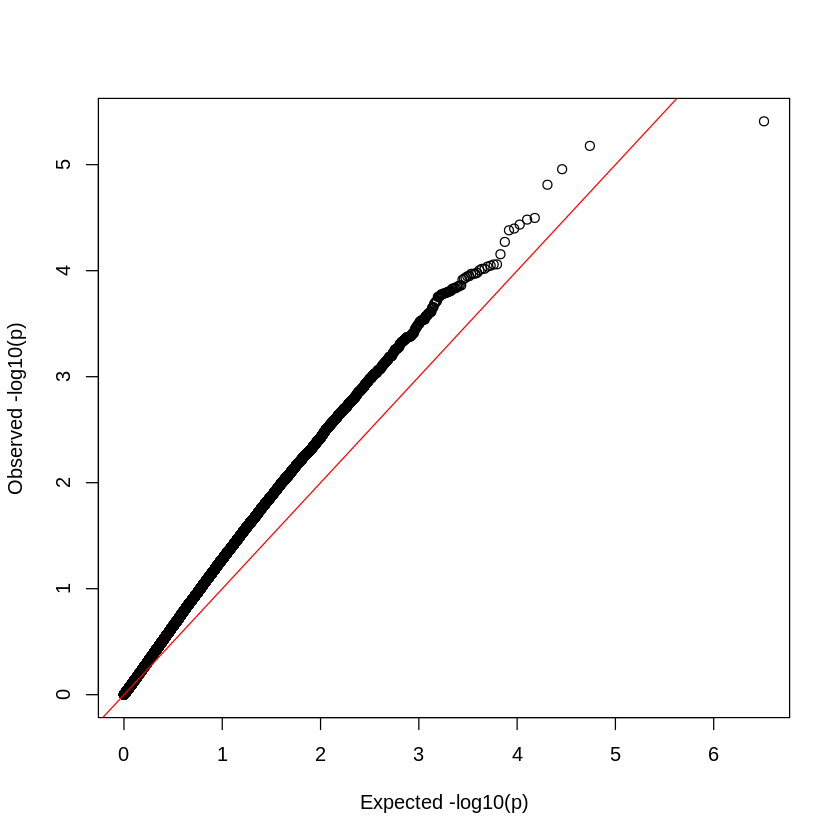

In [11]:
#lrt_sl_null <- lrt_sl_null[LRT > 0][order(LRT)][,quantile:=1:nrow(lrt_sl_null[LRT > 0])/nrow(lrt_sl_null[LRT > 0])] #quantiles for observed lrt
#lrt_sl_null_filt <- lrt_sl_null[LRT >0][Chromosome %in% as.character(seq(1,24,1))][, pvalue:=pchisq(LRT, df=1, lower=F)]
#png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/lrt_null_qq_sl.png")

qqplot(-log10(lrt_sl_null_filt$pvalue), -log10(lrt_filt_sl$pvalue), xlab = "Expected -log10(p)", ylab="Observed -log10(p)")
abline(0, 1, col = "red")
#dev.off()

In [ ]:
#lrt_ucrit_null <- lrt_ucrit_null[LRT > 0][order(LRT)][,quantile:=1:nrow(lrt_ucrit_null[LRT > 0])/nrow(lrt_ucrit_null[LRT > 0])] #quantiles for observed lrt
lrt_ucrit_null_filt <- lrt_ucrit_null[LRT >0][Chromosome %in% as.character(seq(1,24,1))][, pvalue:=pchisq(LRT, df=1, lower=F)]
#png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/lrt_null_qq_ucrit.png")
qqplot(-log10(lrt_ucrit_null$pvalue), -log10(lrt_filt_ucrit$pvalue), xlab = "Expected -log10(p)", ylab="Observed -log10(p)")
abline(0, 1, col = "red")
#dev.off()

In [786]:
str(lrt_ucrit_null)

Classes ‘data.table’ and 'data.frame':	697164900 obs. of  11 variables:
 $ Chromosome   : chr  "1" "1" "1" "1" ...
 $ Position     : int  327 479 480 529 787 1492 1830 2177 2202 2382 ...
 $ Major        : chr  "G" "T" "T" "C" ...
 $ Minor        : chr  "T" "A" "G" "T" ...
 $ Frequency    : num  0.147 0.098 0.281 0.07 0.453 ...
 $ N            : int  159 159 159 159 159 159 159 159 159 159 ...
 $ LRT          : num  -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
 $ high_WT/HE/HO: chr  "4/1/0" "15/0/0" "0/3/0" "47/4/0" ...
 $ pvalue       : num  NA NA NA NA NA NA NA NA NA NA ...
 $ iteration    : num  1 1 1 1 1 1 1 1 1 1 ...
 $ cutoff       : num  NA NA NA NA NA NA NA NA NA NA ...
 - attr(*, ".internal.selfref")=<externalptr> 


__Get the top 5% of LRT from the null permutations, find snps above that threshold in true association__

In [792]:
cutoff <- round(0.01 *nrow(lrt_ucrit_null_filt[LRT >0]),0)
ucrit_null_top <- lrt_ucrit_null_filt[order(pvalue)][1:cutoff,]
summary(ucrit_null_top$LRT)
candidates_ucrit <- lrt_filt_ucrit[LRT > min(ucrit_null_top$LRT)]
nrow(candidates_ucrit)

Warning message in 1:cutoff:
“numerical expression has 13211441 elements: only the first used”

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  24.91   24.91   24.91   24.91   24.91   24.91 

[1] 0

In [794]:
nrow(lrt_ucrit_null_filt[LRT >0])

[1] 13211441

In [791]:
cutoff

[1] 132848

In [468]:
quantile(lrt_ucrit_null_filt$pvalue, .05, na.rm=T)[[1]]

[1] 0.0330597

__Also for SL phenotype__

In [274]:
cutoff <- round(0.01 *nrow(lrt_sl_null[LRT >0]),0)
sl_null_top <- lrt_sl_null[LRT >0][order(-LRT)][1:cutoff,]
summary(sl_null_top$LRT)
candidates_sl <- lrt_filt_sl[LRT > min(sl_null_top$LRT)]
nrow(candidates_sl)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  6.445   6.928   7.614   8.139   8.785  26.200 

[1] 2676

__Calculate the BH critical threshold__

In [569]:
#what about a chromosomal level cutoff
lrt_filt_ucrit_chrom <- lrt_filt_ucrit[Chromosome %like% "chr"][order(pvalue), rank_chrom :=  seq_len(.N), "Chromosome"][
    , padjbh_chrom := lapply(.SD, function(x){(rank_chrom/.N)*0.05}), by = "Chromosome"]
lrt_filt_ucrit_chrom_sig=lrt_filt_ucrit_chrom[pvalue<padjbh_chrom][, bh_critical := padjbh_chrom]
ucrit_threshold <- left_join(lrt_filt_ucrit_chrom, lrt_filt_ucrit_chrom_sig[, .(Chromosome, bh_critical)])
candidate_ucrit_chrom_bh <- ucrit_threshold[pvalue < bh_critical][Chromosome %like% "chr"]
nrow(candidate_ucrit_chrom_bh)

Joining, by = "Chromosome"

[1] 1

In [561]:
head(lrt_filt_ucrit_chrom_sig)
head(lrt_filt_ucrit_chrom)
head(ucrit_threshold)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,...,emIter,locus,pvalue,SNP,quantile,exp_lrt_ucrit,min_pvalue,rank_chrom,padjbh_chrom,bh_critical


Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,SE,emIter,locus,pvalue,SNP,quantile,exp_lrt_ucrit,min_pvalue,rank_chrom,padjbh_chrom


Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,...,emIter,locus,pvalue,SNP,quantile,exp_lrt_ucrit,min_pvalue,rank_chrom,padjbh_chrom,bh_critical


In [178]:
lrt_filt_ucrit <- lrt_filt_ucrit[order(pvalue)]
lrt_filt_ucrit$rank=1:NROW(lrt_filt_ucrit) #rank snp by order
lrt_filt_ucrit$padjBH=(lrt_filt_ucrit$rank/nrow(lrt_filt_ucrit))*.2#then calculate the critical by dividing each rank by the total number of snps, and then multiply by fdr
lrt_filt_ucrit_sig=lrt_filt_ucrit[lrt_filt_ucrit$pvalue<lrt_filt_ucrit$padjBH,]
lrt_filt_ucrit_sig

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,SE,emIter,locus,pvalue,SNP,Chromosome_man,rank,padjBH


In [260]:
candidate_sl_chrom_bh

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,locus,pvalue,SNP,quantile,exp_lrt_sl,rank_chrom,padjbh_chrom,bh_critical
10000591,17920,A,G,0.175867,147,3.132857,27/10/0,PYAM01000059.1:17920,0.047059631926,r105787,0.8677748,2.275955,1,0.050000000000,0.050000000000
10000441,35350,A,G,0.302674,147,6.180107,11/11/2,PYAM01000044.1:35350,0.007301614245,r105786,0.9713727,4.814287,1,0.050000000000,0.050000000000
10000401,51479,T,A,0.083430,147,8.711015,96/15/0,PYAM01000040.1:51479,0.001735013314,r105777,0.9922037,7.067781,1,0.002631578947,0.002631578947
10002151,33965,G,C,0.054872,147,10.227428,111/10/0,PYAM01000215.1:33965,0.000750186213,r105932,0.9965832,8.454853,1,0.025000000000,0.025000000000
10001001,35657,A,G,0.323038,147,11.026242,12/24/2,PYAM01000100.1:35657,0.000484594273,r105886,0.9978291,9.195394,1,0.000595238095,0.000595238095
4,7504287,A,G,0.190875,147,17.032842,33/23/0,4:7504287,0.000019347812,r15367,0.9999434,18.267630,2,0.000019956097,0.000019956097
15,4387764,C,T,0.264829,147,18.680059,25/26/1,15:4387764,0.000008107700,r68417,0.9999717,20.011605,1,0.000010076582,0.000010076582
4,3491306,A,G,0.234541,147,19.323208,34/23/0,4:3491306,0.000005779485,r14897,0.9999811,23.281999,1,0.000009978048,0.000019956097
4,3491306,A,G,0.234541,147,19.323208,34/23/0,4:3491306,0.000005779485,r14897,0.9999811,23.281999,1,0.000009978048,0.000009978048
24,16962690,T,G,0.258409,147,20.290888,10/13/0,24:16962690,0.000003476556,r104351,0.9999906,23.282751,1,0.000014577259,0.000014577259


In [565]:
lrt_filt_sl <- lrt_filt_sl[Chromosome %like% "chr"][order(pvalue)]
lrt_filt_sl$rank=1:NROW(lrt_filt_sl) #rank snp by order
lrt_filt_sl$padjBH=(lrt_filt_sl$rank/nrow(lrt_filt_sl))*.2 #then calculate the critical by dividing each rank by the total number of snps, and then multiply by fdr
lrt_filt_sl_sig=lrt_filt_sl[lrt_filt_sl$pvalue<lrt_filt_sl$padjBH,]
lrt_filt_sl_sig

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,locus,pvalue,SNP,quantile,exp_lrt_sl,rank,padjBH
chr24,16962690,T,G,0.258409,147,20.29089,10/13/0,24:16962690,3.476556e-06,r104351,0.9999906,17.56290,2,3.795823e-06
chr10,406013,C,T,0.253512,147,14.06247,11/13/0,10:406013,9.402687e-05,r42819,0.9995375,12.29891,50,9.489557e-05


In [566]:
candidate_sl_bh <- lrt_filt_sl[Chromosome %like% "chr"][pvalue < max(lrt_filt_sl_sig$pvalue)]
nrow(candidate_sl_bh[order(Chromosome, Position)] )

[1] 49

In [568]:
#chrom level sig for sl
lrt_filt_sl_chrom <- lrt_filt_sl[Chromosome %like% "chr"][order(pvalue), rank_chrom :=  seq_len(.N), "Chromosome"][
    , padjbh_chrom := lapply(.SD, function(x){(rank_chrom/.N)*.05}), by = "Chromosome"]
lrt_filt_sl_chrom_sig=lrt_filt_sl_chrom[pvalue<padjbh_chrom][, bh_critical := padjbh_chrom]
sl_threshold <- left_join(lrt_filt_sl_chrom, lrt_filt_sl_chrom_sig[, .(Chromosome, bh_critical)])
candidate_sl_chrom_bh <- sl_threshold[pvalue < bh_critical, by="Chromosome"][Chromosome %like% "chr"]
nrow(candidate_sl_chrom_bh)

Joining, by = "Chromosome"Warning message in `[.data.table`(sl_threshold, pvalue < bh_critical, by = "Chromosome"):
“Ignoring by= because j= is not supplied”

[1] 6

In [181]:
lrt_filt_ucrit_chrom <- lrt_filt_ucrit[Chromosome %like% "chr"][order(pvalue), rank_chrom :=  seq_len(.N), "Chromosome"][
    , padjbh_chrom := lapply(.SD, function(x){(rank_chrom/.N)*.2}), by = "Chromosome"]
lrt_filt_ucrit_chrom_sig=lrt_filt_ucrit_chrom[pvalue<padjbh_chrom][, bh_critical := padjbh_chrom]
ucrit_threshold <- left_join(lrt_filt_ucrit_chrom, lrt_filt_ucrit_chrom_sig[, .(Chromosome, bh_critical)])
candidate_ucrit_chrom_bh <- ucrit_threshold[pvalue < bh_critical, by="Chromosome"][Chromosome %like% "chr"]
(candidate_ucrit_chrom_bh)

Joining, by = "Chromosome"Warning message in `[.data.table`(ucrit_threshold, pvalue < bh_critical, by = "Chromosome"):
“Ignoring by= because j= is not supplied”

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,...,emIter,locus,pvalue,SNP,Chromosome_man,rank,padjBH,rank_chrom,padjbh_chrom,bh_critical
chr24,6021620,T,C,0.13961,159,18.12104,33/13/0,19.33754,-3.541276,...,21,24:6021620,1.088639e-05,r129188,24,1,1.514005e-06,1,4.637144e-05,4.637144e-05


In [280]:
#only for manhattan plot
lrt_filt_ucrit[, Chromosome := gsub(".","", Chromosome, fixed = T)][, Chromosome := gsub("CM","", Chromosome, fixed = T)][, Chromosome := gsub("PYAM","", Chromosome, fixed = T)]
lrt_filt_ucrit[, Chromosome := as.numeric(Chromosome)]

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”

In [622]:
#only for manhattan plot

lrt_filt_sl[, Chromosome := gsub(".","", Chromosome, fixed = T)][, Chromosome := gsub("CM","", Chromosome, fixed = T)][, Chromosome := gsub("PYAM","", Chromosome, fixed = T)]
lrt_filt_sl[, Chromosome := as.numeric(Chromosome)]

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”

In [64]:
lrt_filt_sl[,Chromosome_man := gsub("chr", "", Chromosome)][, Chromosome_man:=as.numeric(Chromosome_man)]


In [185]:
gw_sl <- quantile(sl_null_chrom$min_pvalue, .05)[[1]]
#gw_sl_null <- dchisq(min(sl_null_top$LRT), df=1)
png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_manhattan_chrom_null_sig.05.png")
qqman::manhattan(lrt_filt_sl, chr="Chromosome_man", bp="Position", p="pvalue", genomewideline = -log10(gw_sl), suggestiveline = F)#highlight =lrt_filt_sl[locus %in% sl_null.2[,locus], SNP]
dev.off()
#gw_sl

png 
  2

In [782]:
tail(lrt_filt_sl[Chromosome %in% as.character(seq(1,24,1)), Chromosome:= as.numeric(Chromosome)])

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,locus,pvalue,SNP,quantile,exp_lrt_sl
9,16335704,G,A,0.194742,147,17.23837,22/12/0,9:16335704,1.735388e-05,r40181,0.9999528,16.72810
21,10182978,G,A,0.275357,147,17.30666,33/31/3,21:10182978,1.673823e-05,r93760,0.9999622,17.16735
15,4387764,C,T,0.264829,147,18.68006,25/26/1,15:4387764,8.107700e-06,r68417,0.9999717,17.42766
4,3491306,A,G,0.234541,147,19.32321,34/23/0,4:3491306,5.779485e-06,r14897,0.9999811,18.41576
24,16962690,T,G,0.258409,147,20.29089,10/13/0,24:16962690,3.476556e-06,r104351,0.9999906,18.76090
11,7825612,T,G,0.206307,147,21.31278,24/11/0,11:7825612,2.035062e-06,r50869,1.0000000,19.86230


In [644]:
candidates_ucrit[, num_chrom:=gsub("chr","", Chromosome)][, locus := paste(num_chrom, Position, sep=":")]

In [31]:
head(ucrit_null.2)
head(sl_null.2)

Chromosome,lower.2,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,SE,emIter,locus,pvalue,SNP
chr13,8.740379e-05,34982957,A,T,0.143409,159,14.54706,30/10/0,15.54311,-3.400393,1.096761,28,13:34982957,7.255504e-05,r75803
chr24,9.140866e-05,6021620,T,C,0.139610,159,18.12104,33/13/0,19.33754,-3.541276,1.039912,21,24:6021620,1.088639e-05,r129188


Chromosome,lower.2,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,locus,pvalue,SNP
chr1,6.355368e-05,41916980,A,G,0.227216,147,15.21617,13/12/0,1:41916980,5.077024e-05,r3455
chr10,4.399612e-05,13433683,G,A,0.232027,147,16.86947,11/14/0,10:13433683,2.109602e-05,r44565
chr11,6.412735e-05,424270,C,T,0.194103,147,15.15145,13/11/0,11:424270,5.255172e-05,r49516
chr11,6.412735e-05,7825612,T,G,0.206307,147,21.31278,24/11/0,11:7825612,2.035062e-06,r50869
chr12,7.824067e-05,993809,C,T,0.236088,147,16.79673,10/11/0,12:993809,2.192469e-05,r54294
chr13,7.046379e-05,20903430,C,T,0.224606,147,15.30296,13/14/1,13:20903430,4.847598e-05,r58882


In [29]:
quantile(ucrit_null_chrom$min_pvalue, 0.2)
quantile(sl_null_chrom$min_pvalue, 0.2)

20% 
6.888711e-05

20% 
6.095076e-05

In [66]:
lrt_filt_ucrit[,Chromosome_man := gsub("chr", "", Chromosome)][, Chromosome_man:=as.numeric(Chromosome_man)]
tail(lrt_filt_ucrit)#[Chromosome %like% "chr"][,Chromosome_man := gsub("chr", "", Chromosome)][, Chromosome_man:=as.numeric(Chromosome_man)])

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,SE,emIter,locus,pvalue,SNP,Chromosome_man
chr24,23705403,G,A,0.160159,159,1.962843,25/10/0,NaN,NaN,NaN,0,24:23705403,0.1067189,r132095,24
chr24,23705578,G,C,0.126338,159,1.006288,33/11/0,NaN,NaN,NaN,0,24:23705578,0.2404564,r132096,24
chr24,23705615,G,A,0.057987,159,0.079244,105/10/0,NaN,NaN,NaN,0,24:23705615,1.3621322,r132097,24
chr24,23705639,A,C,0.090435,159,0.025419,98/14/0,NaN,NaN,NaN,0,24:23705639,2.4706497,r132098,24
chr24,23705661,T,A,0.132220,159,0.025550,50/11/0,NaN,NaN,NaN,0,24:23705661,2.4641464,r132099,24
chr24,23722269,A,G,0.099589,159,0.554008,95/12/0,NaN,NaN,NaN,0,24:23722269,0.4063037,r132100,24


In [184]:
gw_ucrit <- quantile(ucrit_null_chrom$min_pvalue, .05)[[1]]
png("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_manhattan_chrom_null_sig.05.png")
qqman::manhattan(lrt_filt_ucrit, chr="Chromosome_man", bp="Position", p="pvalue", genomewideline = -log10(gw_ucrit), suggestiveline = F,ylim = c(0, 6)) #, highlight =lrt_filt_ucrit[locus %in% ucrit_null.2[,locus], SNP]
dev.off()
#gw_ucrit

png 
  2

In [577]:
head(candidate_ucrit_chrom_bh[, .(Chromosome, Position)])
head(ucrit_null.25[, .(Chromosome, Position)])
head(candidate_sl_chrom_bh[, .(Chromosome, Position)])

Chromosome,Position
chr24,6021620


Chromosome,Position
chr24,6021620


Chromosome,Position
chr11,7825612
chr24,16962690
chr4,3491306
chr4,3491306
chr15,4387764
chr4,7504287


In [157]:
ucrit_cand <- rbind(ucrit_null.2[, .(Chromosome, Position)], lrt_filt_ucrit[pvalue <=gw_ucrit, .(Chromosome, Position)])
ucrit_cand <- unique(ucrit_cand)
(ucrit_cand)
gw_ucrit

Chromosome,Position
chr13,34982957
chr24,6021620
chr5,37582791


[1] 6.888711e-05

In [158]:
lrt_filt_ucrit[Chromosome=="chr13" & Position=="34982957"]

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,SE,emIter,locus,pvalue,SNP,Chromosome_man
chr13,34982957,A,T,0.143409,159,14.54706,30/10/0,15.54311,-3.400393,1.096761,28,13:34982957,7.255504e-05,r75803,13


In [159]:
sl_cand <- rbind(sl_null.2[, .(Chromosome, Position)], lrt_filt_sl[pvalue <=gw_sl, .(Chromosome, Position)])
sl_cand <- unique(sl_cand)
(sl_cand)

Chromosome,Position
chr1,41916980
chr10,13433683
chr11,424270
chr11,7825612
chr12,993809
chr13,20903430
chr15,4387764
chr17,32662287
chr20,16885735
chr20,32392972


In [62]:
fwrite(ucrit_cand[,.(Chromosome=gsub("chr", "", Chromosome), start=Position-2000, end=Position+2000)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/null_candidates_ucrit_loci2kbp.bed", sep="\t", col.names = F)

In [77]:
ucrit_cand[,.(Chromosome=gsub("chr", "", Chromosome), start=Position-3000, end=Position+3000)]

Chromosome,start,end
13,34979957,34985957
24,6018620,6024620
5,37579791,37585791


In [68]:
fwrite(sl_cand[,.(Chromosome=gsub("chr", "", Chromosome), start=Position-2000, end=Position+2000)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/null_candidates_sl_loci2kbp.bed", sep="\t", col.names = F)

__write out the candidate positions to find closest feature in percula genome or blast__

In [601]:
candidates_sl_bedops <- candidates_sl[,.( Chromosome, start=Position-50, end=Position+50)]#, range=paste0(start, end, sep="-"))]
candidates_ucrit_bedops <- candidates_ucrit[,.( Chromosome, start=Position-50, end=Position+50)]#, range=paste0(start, end, sep="-"))]
#fwrite(candidates_sl_bedops[,.(Chromosome, start, end)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/candidates_sl_loci50bp.bed", sep="\t", col.names = F)
#fwrite(candidates_ucrit_bedops[,.(Chromosome, start, end)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/candidates_ucrit_loci50bp.bed", sep="\t", col.names = F)

__read in and sort the blast results__

In [144]:
sl_oce <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_null_7U1U4RGP016-Alignment-HitTable.csv")

In [148]:
sl_oce_best <- unique(sl_oce[, .(seqid=V1, accession=V2, per_id=V3)][per_id==max(per_id), .(accession, per_id), by="seqid"], by="seqid")

In [152]:
(sl_oce_best)

seqid,accession,per_id
1:41913981-41919980,XM_035954527.1,100
4:3488307-3494306,XM_023271958.2,100
5:26593316-26599315,XM_023282415.2,100
7:5225068-5231067,XM_023271457.2,100
7:5424398-5430397,XR_004848333.1,100
7:27878404-27884403,XM_023281584.2,100
9:4200955-4206954,XM_023272690.2,100
9:16332705-16338704,XM_023285552.2,100
10:13430684-13436683,XM_023282991.2,100
11:7822613-7828612,XM_023267040.2,100


In [122]:
zebra_sl <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/zebra_sl_candidates_results_null_1kbp.out")
blast_header <- c("qseqid", "sseqid", "sstart", "send", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "evalue", "bitscore")
setnames(zebra_sl, blast_header)
head(zebra_sl)
best_blast_sl <- zebra_sl[, .SD[which.max(bitscore)], by =qseqid] #sort by best evalue for each locus
best_blast_sl[, `:=`(sstart=ifelse(sstart > send, send, sstart), send=ifelse(sstart > send, sstart, send))]
fwrite(best_blast_sl[,.(sseqid, sstart, send)],"/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/best_blast_sl_null_1kbp_zebra.bed", col.names = F, sep="\t")


qseqid,sseqid,sstart,send,pident,length,mismatch,gapopen,qstart,qend,evalue,bitscore
7:5426398-5428397,20,35263083,35263056,100.000,28,0,0,1420,1447,0.013000,52.8
15:4386765-4388764,CHR_ALT_CTG17_1_27,48769077,48769044,97.059,34,1,0,322,355,0.000278,58.4
15:4386765-4388764,17,48764527,48764494,97.059,34,1,0,322,355,0.000278,58.4
15:4386765-4388764,17,48907783,48907756,100.000,28,0,0,737,764,0.013000,52.8
15:4386765-4388764,CHR_ALT_CTG23_1_27,25778949,25778914,94.444,36,2,0,322,357,0.001000,56.5
15:4386765-4388764,23,25781804,25781769,94.444,36,2,0,322,357,0.001000,56.5


In [121]:
head(best_blast_sl)

qseqid,sseqid,sstart,send,pident,length,mismatch,gapopen,qstart,qend,evalue,bitscore
7:5426398-5428397,20,35263056,35263083,100.000,28,0,0,1420,1447,1.30e-02,52.8
15:4386765-4388764,CHR_ALT_CTG17_1_27,48769044,48769077,97.059,34,1,0,322,355,2.78e-04,58.4
17:17029429-17031428,16,8355504,8355553,96.000,50,2,0,1695,1744,1.65e-11,82.4


In [89]:
zebra_ucrit <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/zebra_ucrit_candidates_results_null3kbp.out")
blast_header <- c("qseqid", "sseqid", "sstart", "send", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "evalue", "bitscore")
setnames(zebra_ucrit, blast_header)
head(zebra_ucrit)
best_blast_ucrit <- zebra_ucrit[, .SD[which.max(bitscore)], by =qseqid] #sort by best evalue for each locus
best_blast_ucrit[, `:=`(sstart=ifelse(sstart > send, send, sstart), send=ifelse(sstart > send, sstart, send))]
fwrite(best_blast_ucrit[,.(sseqid, sstart, send)],"/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/best_blast_ucrit_null_3kbp_zebra.bed", col.names = F, sep="\t")


qseqid,sseqid,sstart,send,pident,length,mismatch,gapopen,qstart,qend,evalue,bitscore
5:37579792-37585791,2,1834880,1834703,77.778,180,31,9,927,1099,3.85e-17,102.0
5:37579792-37585791,2,30141776,30141631,79.592,147,27,2,988,1132,3.85e-17,102.0
5:37579792-37585791,2,10759695,10759610,85.393,89,8,3,981,1067,1.08e-12,87.9
5:37579792-37585791,2,6092430,6092457,100.000,28,0,0,3150,3177,3.90e-02,52.8
5:37579792-37585791,1,57318093,57318181,88.043,92,4,5,980,1067,3.85e-17,102.0
5:37579792-37585791,1,5343508,5343363,78.912,147,28,3,988,1132,1.79e-15,97.1


__read in the corresponding genes__

In [123]:
zebra_sl_genes <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_blast_results_null1kbp_candidates_closest_zebra.bed", sep="\t", fill=T)  
gff_names <- c("seqid", "feature_start", "feature_end", "feature_id", "score", "strand", "unkn", "feature_type", "phase", "attributes")
setnames(zebra_sl_genes, gff_names)
head(zebra_sl_genes[feature_type=="gene"])

Warning message in fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_blast_results_null1kbp_candidates_closest_zebra.bed", :
“Stopped early on line 41209. Expected 10 fields but found 12. Consider fill=TRUE and comment.char=. First discarded non-empty line: <<20	9603	16852	transcript:ENSDART00000129277	.	-	ensembl	mRNA	.	ID=transcript:ENSDART00000129277;Parent=gene:ENSDARG00000087933;Name=zgc:174972-201;biotype=protein_coding;transcript_id=ENSDART00000129277;version=3|20	35263056	35263083>>”

seqid,feature_start,feature_end,feature_id,score,strand,unkn,feature_type,phase,attributes
1,6407,12027,gene:ENSDARG00000099104,.,-,ensembl_havana,gene,.,ID=gene:ENSDARG00000099104;Name=rpl24;biotype=protein_coding;description=ribosomal protein L24 [Source:NCBI gene%3BAcc:192301];gene_id=ENSDARG00000099104;logic_name=ensembl_havana_gene;version=1|NA
1,11821,16373,gene:ENSDARG00000102407,.,+,ensembl_havana,gene,.,ID=gene:ENSDARG00000102407;Name=cep97;biotype=protein_coding;description=centrosomal protein 97 [Source:ZFIN%3BAcc:ZDB-GENE-031030-11];gene_id=ENSDARG00000102407;logic_name=ensembl_havana_gene;version=2|NA
1,18715,23389,gene:ENSDARG00000102097,.,+,havana,gene,.,ID=gene:ENSDARG00000102097;Name=nfkbiz;biotype=protein_coding;description=nuclear factor of kappa light polypeptide gene enhancer in B-cells inhibitor%2C zeta [Source:ZFIN%3BAcc:ZDB-GENE-071024-1];gene_id=ENSDARG00000102097;logic_name=havana;version=2|NA
1,25584,27255,gene:ENSDARG00000099319,.,+,ensembl,gene,.,ID=gene:ENSDARG00000099319;Name=CU651657.1;biotype=protein_coding;gene_id=ENSDARG00000099319;logic_name=ensembl_danio_rerio;version=1|NA
1,27689,34330,gene:ENSDARG00000099640,.,+,ensembl_havana,gene,.,ID=gene:ENSDARG00000099640;Name=eed;biotype=protein_coding;description=embryonic ectoderm development [Source:NCBI gene%3BAcc:550463];gene_id=ENSDARG00000099640;logic_name=ensembl_havana_gene;version=1|NA
1,36551,39191,gene:ENSDARG00000104071,.,+,ensembl_havana,gene,.,ID=gene:ENSDARG00000104071;Name=hikeshi;biotype=protein_coding;description=heat shock protein nuclear import factor hikeshi [Source:NCBI gene%3BAcc:550239];gene_id=ENSDARG00000104071;logic_name=ensembl_havana_gene;version=1|NA


In [124]:
nrow(zebra_sl_genes)

[1] 41208

In [114]:
zebra_ucrit_genes <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_blast_results_null3kbp_candidates_closest_zebra.bed", sep="\t", fill=T)  
gff_names <- c("seqid", "feature_start", "feature_end", "feature_id", "score", "strand", "unkn", "feature_type", "phase", "attributes")
setnames(zebra_ucrit_genes, gff_names)
head(zebra_ucrit_genes[feature_type=="gene"])

Warning message in fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_blast_results_null3kbp_candidates_closest_zebra.bed", :
“Stopped early on line 36715. Expected 10 fields but found 12. Consider fill=TRUE and comment.char=. First discarded non-empty line: <<2	18865	22535	gene:ENSDARG00000100145	.	-	ensembl	gene	.	ID=gene:ENSDARG00000100145;Name=CABZ01092282.1;biotype=protein_coding;gene_id=ENSDARG00000100145;logic_name=ensembl_danio_rerio;version=2|2	1834703	1834880>>”

seqid,feature_start,feature_end,feature_id,score,strand,unkn,feature_type,phase,attributes
1,6407,12027,gene:ENSDARG00000099104,.,-,ensembl_havana,gene,.,ID=gene:ENSDARG00000099104;Name=rpl24;biotype=protein_coding;description=ribosomal protein L24 [Source:NCBI gene%3BAcc:192301];gene_id=ENSDARG00000099104;logic_name=ensembl_havana_gene;version=1|NA
1,11821,16373,gene:ENSDARG00000102407,.,+,ensembl_havana,gene,.,ID=gene:ENSDARG00000102407;Name=cep97;biotype=protein_coding;description=centrosomal protein 97 [Source:ZFIN%3BAcc:ZDB-GENE-031030-11];gene_id=ENSDARG00000102407;logic_name=ensembl_havana_gene;version=2|NA
1,18715,23389,gene:ENSDARG00000102097,.,+,havana,gene,.,ID=gene:ENSDARG00000102097;Name=nfkbiz;biotype=protein_coding;description=nuclear factor of kappa light polypeptide gene enhancer in B-cells inhibitor%2C zeta [Source:ZFIN%3BAcc:ZDB-GENE-071024-1];gene_id=ENSDARG00000102097;logic_name=havana;version=2|NA
1,25584,27255,gene:ENSDARG00000099319,.,+,ensembl,gene,.,ID=gene:ENSDARG00000099319;Name=CU651657.1;biotype=protein_coding;gene_id=ENSDARG00000099319;logic_name=ensembl_danio_rerio;version=1|NA
1,27689,34330,gene:ENSDARG00000099640,.,+,ensembl_havana,gene,.,ID=gene:ENSDARG00000099640;Name=eed;biotype=protein_coding;description=embryonic ectoderm development [Source:NCBI gene%3BAcc:550463];gene_id=ENSDARG00000099640;logic_name=ensembl_havana_gene;version=1|NA
1,36551,39191,gene:ENSDARG00000104071,.,+,ensembl_havana,gene,.,ID=gene:ENSDARG00000104071;Name=hikeshi;biotype=protein_coding;description=heat shock protein nuclear import factor hikeshi [Source:NCBI gene%3BAcc:550239];gene_id=ENSDARG00000104071;logic_name=ensembl_havana_gene;version=1|NA


In [115]:
nrow(zebra_ucrit)

[1] 159

__with the nearest features results, write out the regions to extract from fafsa and blast against zebra__

In [603]:
gff_names <- c("seqid", "start","locus", "feature_start", "feature_end", "feature_id", "score", "strand", "unkn", "feature_type", "phase", "attributes")
sl_nearest <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_results_candidates_50bp_percula_nearest.bed", sep="\t", fill = T)
setnames(sl_nearest, gff_names)

In [615]:
ucrit_nearest[,.(seqid=gsub("chr","", seqid, fixed=T), feature_start, feature_end)][]

seqid,feature_start,feature_end
24,6018402,6019755
24,6018402,6019755


In [616]:
head(ucrit_nearest)
fwrite(ucrit_nearest[,.(seqid=gsub("chr","", seqid, fixed=T), feature_start, feature_end)],"/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/candidates_ucrit_nearest.bed", sep="\t",col.names = F)

seqid,start,locus,feature_start,feature_end,feature_id,score,strand,unkn,feature_type,phase,attributes
chr24,6021570,6021670|chr24,6018402,6019755,APERC1_00025852,.,-,maker,gene,.,ID=APERC1_00025852|-1816
chr24,6021570,6021670|chr24,6018402,6019755,APERC1_00025852,.,-,maker,gene,.,ID=APERC1_00025852|-1816


In [617]:
fwrite(sl_nearest[,.(seqid=gsub("chr","", seqid, fixed=T), feature_start, feature_end)],"/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/candidates_sl_nearest.bed", sep="\t",col.names = F)

In [12]:
all_sl_bedops <- lrt_filt_sl[,.(locus, Chromosome, start=Position-50, end=Position+50)][Chromosome %like% "chr"]#[,Chromosome := paste0("chr", Chromosome, sep="")]#, range=paste0(start, end, sep="-"))]
all_ucrit_bedops <- lrt_filt_ucrit[,.(locus, Chromosome, start=Position-50, end=Position+50)][Chromosome %like% "chr"]#[,Chromosome := paste0("chr", Chromosome, sep="")]#, range=paste0(start, end, sep="-"))]
#fwrite(all_sl_bedops[,.(Chromosome, start, end)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/all_sl_loci50bp.bed", sep="\t", col.names = F)
#fwrite(all_ucrit_bedops[,.(Chromosome, start, end)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/all_ucrit_loci50bp.bed", sep="\t", col.names = F)#

__once you get the closest feature from apercula, read in here to get the feature start and end position, use seqk to extract the regions from the reference fasta and blast against the zebrafish genome. Join that with the__

In [343]:
#were any of the genes annotate in frenatus or zebra?
blast_sl <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/zebra_sl_candidates_results.out")
best_blast_sl <- blast_sl[, .SD[which.min(evalue)], by ="qseqid"] #sort by best evalue for each locus
best_blast_sl[, `:=`(sstart=ifelse(sstart > send, send, sstart), send=ifelse(sstart > send, sstart, send))]
zebra_sl <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_blast_results_candidates_closest_zebra.bed", fill=T)


In [347]:
head(fread("/data/katrinac/APPC_sequencing/Genome/best_blast_sl_3kbp_zebra_sort.bed"))

V1,V2,V3
1,5343363,5343508
1,32243461,32243590
1,47633402,47633450
10,6755484,6755528
10,38037735,38037839
11,7194604,7194759


In [348]:
gff_names <- c("sseqid", "feature_start","feature_end", "feature_id", "phase", "strand", "source", "feature_type", "unkn", "attributes", "qstart", "qend")
setnames(zebra_sl, gff_names)
zebra_sl[, sseqid:=as.character(sseqid)]

In [349]:
head(zebra_sl)

sseqid,feature_start,feature_end,feature_id,phase,strand,source,feature_type,unkn,attributes,qstart,qend
1,0,59578282,chromosome:1,.,.,GRCz11,chromosome,.,"ID=chromosome:1;Alias=CM002885.2,NC_007112.7|1",5343363,5343508
1,6407,6679,.,.,-,ensembl_havana,three_prime_UTR,.,Parent=transcript:ENSDART00000164359|1,5343363,5343508
1,6407,6760,.,.,-,ensembl_havana,exon,.,Parent=transcript:ENSDART00000164359;Name=ENSDARE00001184741;constitutive=0;ensembl_end_phase=-1;ensembl_phase=0;exon_id=ENSDARE00001184741;rank=6;version=1|1,5343363,5343508
1,6407,12027,gene:ENSDARG00000099104,.,-,ensembl_havana,gene,.,ID=gene:ENSDARG00000099104;Name=rpl24;biotype=protein_coding;description=ribosomal protein L24 [Source:NCBI gene%3BAcc:192301];gene_id=ENSDARG00000099104;logic_name=ensembl_havana_gene;version=1|1,5343363,5343508
1,6407,12027,transcript:ENSDART00000164359,.,-,ensembl_havana,mRNA,.,ID=transcript:ENSDART00000164359;Parent=gene:ENSDARG00000099104;Name=rpl24-203;biotype=protein_coding;transcript_id=ENSDART00000164359;version=1|1,5343363,5343508
1,6641,6760,.,.,-,havana,exon,.,Parent=transcript:ENSDART00000157701;Name=ENSDARE00001177024;constitutive=0;ensembl_end_phase=-1;ensembl_phase=-1;exon_id=ENSDARE00001177024;rank=3;version=1|1,5343363,5343508


In [342]:
head(zebra_sl)
head(best_blast_sl[,.(qseqid, sseqid, sstart, send)])

sseqid,sstart,locus,feature_start,feature_end,feature_id,score,strand,unkn,feature_type,phase,attributes
1,0,59578282,chromosome:1,.,.,GRCz11,chromosome,.,"ID=chromosome:1;Alias=CM002885.2,NC_007112.7|1",5343363,5343508
1,6407,6679,.,.,-,ensembl_havana,three_prime_UTR,.,Parent=transcript:ENSDART00000164359|1,5343363,5343508
1,6407,6760,.,.,-,ensembl_havana,exon,.,Parent=transcript:ENSDART00000164359;Name=ENSDARE00001184741;constitutive=0;ensembl_end_phase=-1;ensembl_phase=0;exon_id=ENSDARE00001184741;rank=6;version=1|1,5343363,5343508
1,6407,12027,gene:ENSDARG00000099104,.,-,ensembl_havana,gene,.,ID=gene:ENSDARG00000099104;Name=rpl24;biotype=protein_coding;description=ribosomal protein L24 [Source:NCBI gene%3BAcc:192301];gene_id=ENSDARG00000099104;logic_name=ensembl_havana_gene;version=1|1,5343363,5343508
1,6407,12027,transcript:ENSDART00000164359,.,-,ensembl_havana,mRNA,.,ID=transcript:ENSDART00000164359;Parent=gene:ENSDARG00000099104;Name=rpl24-203;biotype=protein_coding;transcript_id=ENSDART00000164359;version=1|1,5343363,5343508
1,6641,6760,.,.,-,havana,exon,.,Parent=transcript:ENSDART00000157701;Name=ENSDARE00001177024;constitutive=0;ensembl_end_phase=-1;ensembl_phase=-1;exon_id=ENSDARE00001177024;rank=3;version=1|1,5343363,5343508


qseqid,sseqid,sstart,send
2:5427895-5437894,CHR_ALT_CTG8_1_11,26631634,26631715
2:23958024-23968023,16,20607110,20607141
3:14330725-14340724,3,56308670,56308830
5:26591316-26601315,16,55120665,55120876
6:1316877-1326876,6,55332457,55332555
7:5223068-5233067,16,52608493,52608671


In [371]:
#join the gene ids for zebra with the query sequence position
test <- left_join(zebra_sl, best_blast_sl[,.(qseqid, sseqid, sstart, send)], by=c(qstart="sstart", "sseqid"))

In [1]:
#test[!is.na(qseqid)&feature_type=="gene"]

In [125]:
head(lrt_filt_sl)

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,locus,pvalue,SNP,Chromosome_man
chr1,10004,A,G,0.109734,147,0.096277,42/14/0,1:10004,1.2253002,r1,1
chr1,32316,T,G,0.339790,147,0.843309,11/20/0,1:32316,0.2849669,r2,1
chr1,32326,T,C,0.206107,147,0.842760,20/11/0,1:32326,0.2851380,r3,1
chr1,32350,A,G,0.299364,147,0.125366,10/10/1,1:32350,1.0582720,r4,1
chr1,32897,C,T,0.198828,147,1.057497,13/11/0,1:32897,0.2286325,r5,1
chr1,33219,A,G,0.245286,147,0.272930,13/12/0,1:33219,0.6662212,r6,1


In [38]:
#load in the gff file from closest-feature
gff_names <- c("seqid", "start","locus", "feature_start", "feature_end", "feature_id", "score", "strand", "unkn", "feature_type", "phase", "attributes")
sl_nearest <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sorted_all_sl_50bp_percula_nearest.bed", sep="\t", fill = T)
setnames(sl_nearest, gff_names)

#split the attributs column to get the gene name and the go terms
split <- sl_nearest[, c('gene_id', 'protein_family', 'go_term_dist'):= tstrsplit(attributes, ";")][, c('go_term', 'dist_bp'):= tstrsplit(go_term_dist, "|", fixed=T),by="gene_id"][dist_bp <=5000]

go_sl <- split[!is.na(gene_id), .(gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term))][, go_term:=gsub(",", " ", go_term)][!is.na(go_term)]
go_sl <- unique(go_sl, by="gene_id")
go_terms <- by(go_sl, go_sl$gene_id,function(x) setNames(x$go_term,x$name))

go_sl <- split[!is.na(gene_id), .(gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term))][, go_term:=gsub(",", " ", go_term)][!is.na(go_term)]
go_sl_vec <- go_sl[, setNames(go_term, gene_id)]

               sl_cand[, locus := paste(Chromosome, Position, sep=":")][,locus := gsub("chr", "", locus)]
           
sl_locus_lrt <- left_join(all_sl_bedops, lrt_filt_sl)[, sig:=ifelse(locus %in% sl_cand$locus, 1, 0)][, .(Chromosome, start, end, sig)]
genes_score <- left_join(sl_locus_lrt, split[, .(seqid, start, feature_id)], by="start")[, .(feature_id, sig)][!is.na(feature_id)]
genes_score <- unique(genes_score[order(-sig)], by="feature_id")
genes_score_vec <- genes_score[, setNames(sig, feature_id)]
               
#sig <- max(candidates_sl$pvalue)
#sig <- max(lrt_filt_sl_sig$pvalue)
GOdata <- new("topGOdata", description="go analysis of closest genes for a percula phenotype of sl", ontology="BP", allGenes=genes_score_vec, geneSel = function(sig) {sig == 1}, annotationFun=annFUN.gene2GO, gene2GO=go_sl_vec)  

test.stat <- new("classicCount", testStatistic = GOFisherTest, name = "Fisher test")
resultFisher <- getSigGroups(GOdata, test.stat)
#pValue.classic <- score(resultFisher)

#test.stat <- new("weightCount", testStatistic = GOFisherTest, name = "Fisher test", sigRatio = "ratio")
#resultWeight <- getSigGroups(GOdata, test.stat)

test.stat <- new("elimScore", testStatistic = GOKSTest, name = "Fisher test", cutOff = 0.01)
resultElim <- getSigGroups(GOdata, test.stat)

allRes <- GenTable(GOdata, classic = resultFisher, elim= resultElim)

Joining, by = c("locus", "Chromosome")Warning message in `[.data.table`(left_join(all_sl_bedops, lrt_filt_sl), , `:=`(sig, :
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”
Building most specific GOs .....
	( 80 GO terms found. )

Build GO DAG topology ..........
	( 424 GO terms and 810 relations. )

Annotating nodes ...............
	( 300 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 10 nontrivial nodes
		 parameters: 
			 test stat

In [39]:
nrow(genes_score[sig==1])

[1] 10

In [40]:
nrow(all_sl_bedops[locus %in% sl_cand$locus])

[1] 25

In [42]:
#load in the gff file from closest-feature
gff_names <- c("seqid", "start","locus", "feature_start", "feature_end", "feature_id", "score", "strand", "unkn", "feature_type", "phase", "attributes")
ucrit_nearest <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sorted_all_ucrit_50bp_percula_nearest.bed", sep="\t", fill = T)
setnames(ucrit_nearest, gff_names)

#split the attributs column to get the gene name and the go terms
split <- ucrit_nearest[, c('gene_id', 'protein_family', 'go_term_dist'):= tstrsplit(attributes, ";")][, c('go_term', 'dist_bp'):= tstrsplit(go_term_dist, "|", fixed=T),by="gene_id"][dist_bp <=5000]

go_ucrit <- split[!is.na(gene_id), .(gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term))][, go_term:=gsub(",", " ", go_term)][!is.na(go_term)]
go_ucrit <- unique(go_ucrit, by="gene_id")
go_terms <- by(go_ucrit, go_ucrit$gene_id,function(x) setNames(x$go_term,x$name))

go_ucrit <- split[!is.na(gene_id), .(gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term))][, go_term:=gsub(",", " ", go_term)][!is.na(go_term)]
go_ucrit_vec <- go_ucrit[, setNames(go_term, gene_id)]

               ucrit_cand[, locus := paste(Chromosome, Position, sep=":")][,locus := gsub("chr", "", locus)]
           
ucrit_locus_lrt <- left_join(all_ucrit_bedops, lrt_filt_ucrit)[, sig:=ifelse(locus %in% ucrit_cand$locus, 1, 0)][, .(Chromosome, start, end, sig)]
genes_score <- left_join(ucrit_locus_lrt, split[, .(seqid, start, feature_id)], by="start")[, .(feature_id, sig)][!is.na(feature_id)]
#genes_score <- unique(genes_score[order(-sig)], by="feature_id")
genes_score_vec <- genes_score[, setNames(sig, feature_id)]
               
#sig <- max(candidates_ucrit$pvalue)
#sig <- max(lrt_filt_ucrit_sig$pvalue)
GOdata <- new("topGOdata", description="go analysis of closest genes for a percula phenotype of ucrit", ontology="BP", allGenes=genes_score_vec, geneSel = function(sig) {sig == 1}, annotationFun=annFUN.gene2GO, gene2GO=go_ucrit_vec)  

test.stat <- new("classicCount", testStatistic = GOFisherTest, name = "Fisher test")
resultFisher <- getSigGroups(GOdata, test.stat)
#pValue.classic <- score(resultFisher)

#test.stat <- new("weightCount", testStatistic = GOFisherTest, name = "Fisher test", sigRatio = "ratio")
#resultWeight <- getSigGroups(GOdata, test.stat)

test.stat <- new("elimScore", testStatistic = GOKSTest, name = "Fisher test", cutOff = 0.01)
resultElim <- getSigGroups(GOdata, test.stat)

allRes <- GenTable(GOdata, classic = resultFisher, elim= resultElim)

Joining, by = c("locus", "Chromosome")Warning message in `[.data.table`(left_join(all_ucrit_bedops, lrt_filt_ucrit), , :
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”
Building most specific GOs .....
	( 85 GO terms found. )

Build GO DAG topology ..........
	( 441 GO terms and 849 relations. )

Annotating nodes ...............
	( 328 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 0 nontrivial nodes
		 parameters: 
			 test statistic

In [59]:
genes_score <- left_join(ucrit_locus_lrt, split[, .(seqid, start, feature_id, go_term)], by="start")[, go_term:=gsub("Ontology_term=", "", go_term)][, Position := start+50]#[, .(feature_id, sig)][!is.na(feature_id)]


Warning message in `[.data.table`(left_join(ucrit_locus_lrt, split[, .(seqid, start, :
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”

In [61]:
head(genes_score[sig==1])

Chromosome,start,end,sig,seqid,feature_id,go_term,Position
chr5,37582741,37582841,1,chr5,APERC1_00007364,"GO:0000166,GO:0004812,GO:0005524,GO:0006418,GO:0016876,GO:0043039",37582791
chr13,34982907,34983007,1,NA,NA,NA,34982957
chr24,6021570,6021670,1,NA,NA,NA,6021620


In [49]:
head(genes_score)

Chromosome,start,end,sig,seqid,feature_id
chr1,9954,10054,0,chr1,APERC1_00013921
chr1,32266,32366,0,chr1,APERC1_00013921
chr1,32276,32376,0,chr1,APERC1_00013921
chr1,32300,32400,0,chr1,APERC1_00013921
chr1,32847,32947,0,chr1,APERC1_00013921
chr1,33169,33269,0,chr1,APERC1_00013921


__Pull out the significant features, write out the positions to blast zebra with seqk__

In [34]:
#test.stat <- new("classicScore", testStatistic = GOKSTest, name = "KS tests")
#resultKS <- getSigGroups(GOdata, test.stat)

test.stat <- new("classicCount", testStatistic = GOFisherTest, name = "Fisher test")
resultFisher <- getSigGroups(GOdata, test.stat)
#pValue.classic <- score(resultFisher)

#test.stat <- new("weightCount", testStatistic = GOFisherTest, name = "Fisher test", sigRatio = "ratio")
#resultWeight <- getSigGroups(GOdata, test.stat)

test.stat <- new("elimScore", testStatistic = GOKSTest, name = "Fisher test", cutOff = 0.01)
resultElim <- getSigGroups(GOdata, test.stat)

allRes <- GenTable(GOdata, classic = resultFisher, elim= resultElim)


			 -- Classic Algorithm -- 

		 the algorithm is scoring 10 nontrivial nodes
		 parameters: 
			 test statistic: Fisher test

			 -- Elim Algorithm -- 

		 the algorithm is scoring 424 nontrivial nodes
		 parameters: 
			 test statistic: Fisher test
			 cutOff: 0.01
			 score order: increasing

	 Level 13:	3 nodes to be scored	(0 eliminated genes)

	 Level 12:	7 nodes to be scored	(0 eliminated genes)

	 Level 11:	14 nodes to be scored	(0 eliminated genes)

	 Level 10:	25 nodes to be scored	(0 eliminated genes)

	 Level 9:	33 nodes to be scored	(0 eliminated genes)

	 Level 8:	38 nodes to be scored	(0 eliminated genes)

	 Level 7:	50 nodes to be scored	(0 eliminated genes)

	 Level 6:	65 nodes to be scored	(0 eliminated genes)

	 Level 5:	86 nodes to be scored	(0 eliminated genes)

	 Level 4:	57 nodes to be scored	(0 eliminated genes)

	 Level 3:	33 nodes to be scored	(0 eliminated genes)

	 Level 2:	12 nodes to be scored	(0 eliminated genes)

	 Level 1:	1 nodes to be scored	(0 elimi

In [41]:
(allRes)

GO.ID,Term,Annotated,Significant,Expected,Rank in elim,classic,elim
GO:0007154,cell communication,75,1,0.25,295,0.25,0.73
GO:0007165,signal transduction,75,1,0.25,296,0.25,0.73
GO:0051716,cellular response to stimulus,75,1,0.25,297,0.25,0.73
GO:0050896,response to stimulus,76,1,0.25,262,0.25,0.64
GO:0023052,signaling,79,1,0.26,333,0.26,0.83
GO:0050794,regulation of cellular process,135,1,0.45,218,0.45,0.50
GO:0050789,regulation of biological process,137,1,0.46,261,0.46,0.63
GO:0065007,biological regulation,141,1,0.47,215,0.47,0.48
GO:0009987,cellular process,224,1,0.75,300,0.75,0.73
GO:0008150,biological_process,300,1,1.00,424,1.00,1.00


In [35]:
allRes <- GenTable(GOdata,  elim = resultKS.elim, orderBy = "elim")

ERROR: Error in .local(object, ...): object 'resultKS.elim' not found


In [36]:
allRes

GO.ID,Term,Annotated,Significant,Expected,Rank in elim,classic,elim
GO:0007154,cell communication,75,1,0.25,295,0.25,0.73
GO:0007165,signal transduction,75,1,0.25,296,0.25,0.73
GO:0051716,cellular response to stimulus,75,1,0.25,297,0.25,0.73
GO:0050896,response to stimulus,76,1,0.25,262,0.25,0.64
GO:0023052,signaling,79,1,0.26,333,0.26,0.83
GO:0050794,regulation of cellular process,135,1,0.45,218,0.45,0.50
GO:0050789,regulation of biological process,137,1,0.46,261,0.46,0.63
GO:0065007,biological regulation,141,1,0.47,215,0.47,0.48
GO:0009987,cellular process,224,1,0.75,300,0.75,0.73
GO:0008150,biological_process,300,1,1.00,424,1.00,1.00


In [229]:
fwrite(allRes, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/GO_table_null_cutoff_sl.csv")

In [126]:
#fwrite(allRes, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/GO_table_BH_cutoff_sl.csv")

__make a table of genes and pvalues for results__

In [66]:
sl_gff_join <- split[, .(Chromosome=seqid, Position=start+50, gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term), dist_bp)]
sl_gene_join <- candidate_sl_bh[,.(Chromosome =paste0("chr", Chromosome, ""), Position, Frequency, pvalue, locus)]
sl_gene_ids <- (left_join(sl_gene_join, sl_gff_join))[!is.na(dist_bp)][, chrom_sig_0.05 := ifelse(locus %in% candidate_sl_chrom_bh$locus, "yes", "no")]
#fwrite(sl_gene_ids, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/genes_table_BH_cutoff_sl.csv")

Chromosome,Position,gene_id,go_term,dist_bp
chr1,10004,APERC1_00013921,GO:0005515,16508
chr1,32316,APERC1_00013921,GO:0005515,0
chr1,32326,APERC1_00013921,GO:0005515,0
chr1,32350,APERC1_00013921,GO:0005515,0
chr1,32897,APERC1_00013921,GO:0005515,0
chr1,33219,APERC1_00013921,GO:0005515,0


__for ucrit__

In [758]:
#load in the gff file from closest-feature
gff_names <- c("seqid", "start","locus", "feature_start", "feature_end", "feature_id", "score", "strand", "unkn", "feature_type", "phase", "attributes")
ucrit_nearest <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sorted_all_ucrit_50bp_percula_nearest.bed", sep="\t", fill = T)
setnames(ucrit_nearest, gff_names)

split <- ucrit_nearest[, c('gene_id', 'protein_family', 'go_term_dist'):= tstrsplit(attributes, ";")][, c('go_term', 'dist_bp'):= tstrsplit(go_term_dist, "|", fixed=T),by="gene_id"]

ucrit_locus_lrt <- left_join(all_ucrit_bedops, lrt_filt_ucrit[,Chromosome := paste0("chr", Chromosome, "")][pvalue>1, pvalue:=1])[, .(Chromosome, start, end, pvalue)]
genes_score <- left_join(ucrit_locus_lrt, split[, .(seqid, start, feature_id)], by="start")[, .(feature_id, pvalue)][!is.na(feature_id)]
genes_score <- unique(genes_score, by="feature_id")
genes_score_vec <- genes_score[, setNames(pvalue, feature_id)]

go_ucrit <- split[!is.na(gene_id), .(gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term))][, go_term:=gsub(",", " ", go_term)][!is.na(go_term)]
go_ucrit_vec <- go_ucrit[, setNames(go_term, gene_id)]

sig <- max(candidates_ucrit$pvalue)
#sig <- max(lrt_filt_ucrit_sig$pvalue)
GOdata <- new("topGOdata", description="go analysis of closest genes for a percula phenotype of ucrit", ontology="BP", allGenes=genes_score_vec, geneSel = function(foo) {foo < sig}, annotationFun=annFUN.gene2GO, gene2GO=go_ucrit_vec)

test.stat <- new("classicScore", testStatistic = GOKSTest, name = "KS tests")
resultKS <- getSigGroups(GOdata, test.stat)

test.stat <- new("classicCount", testStatistic = GOFisherTest, name = "Fisher test")
resultFisher <- getSigGroups(GOdata, test.stat)
pValue.classic <- score(resultFisher)

test.stat <- new("weightCount", testStatistic = GOFisherTest, name = "Fisher test", sigRatio = "ratio")
resultWeight <- getSigGroups(GOdata, test.stat)

test.stat <- new("elimScore", testStatistic = GOKSTest, name = "Fisher test", cutOff = 0.01)
resultElim <- getSigGroups(GOdata, test.stat)

allRes <- GenTable(GOdata, classic = resultFisher, elim= resultElim, orderBy = "classic", ranksOf = "classic", topNodes = 40)

Joining, by = c("locus", "Chromosome")
Building most specific GOs .....
	( 88 GO terms found. )

Build GO DAG topology ..........
	( 454 GO terms and 869 relations. )

Annotating nodes ...............
	( 335 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 454 nontrivial nodes
		 parameters: 
			 test statistic: KS tests
			 score order: increasing

			 -- Classic Algorithm -- 

		 the algorithm is scoring 0 nontrivial nodes
		 parameters: 
			 test statistic: Fisher test
Warning message in .local(object, test.stat, ...):
“No enrichment can pe performed - there are no feasible GO terms!”
			 -- Weight Algorithm -- 

		 The algorithm is scoring 0 nontrivial nodes
		 parameters: 
			 test statistic: Fisher test : ratio
Warning message in getSigGroups(GOdata, test.stat):
“No enrichment can pe performed - there are no feasible GO terms!”
			 -- Elim Algorithm -- 

		 the algorithm is scoring 454 nontrivial nodes
		 parameters: 
			 test statisti

In [768]:
ucrit_nearest[seqid=="chr24" & start==6021620-50]

seqid,start,locus,feature_start,feature_end,feature_id,score,strand,unkn,feature_type,phase,attributes,gene_id,protein_family,go_term_dist,go_term,dist_bp
chr24,6021570,6021670|chr24,6018402,6019755,APERC1_00025852,.,-,maker,gene,.,ID=APERC1_00025852|-1816,ID=APERC1_00025852|-1816,NA,NA,NA,NA


In [765]:
head(ucrit_nearest)

seqid,start,locus,feature_start,feature_end,feature_id,score,strand,unkn,feature_type,phase,attributes,gene_id,protein_family,go_term_dist,go_term,dist_bp
chr1,9954,10054|chr1,26561,55859,APERC1_00013921,.,-,maker,gene,.,"ID=APERC1_00013921;Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546;Ontology_term=GO:0005515|16508",ID=APERC1_00013921,"Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546",Ontology_term=GO:0005515|16508,Ontology_term=GO:0005515,16508
chr1,32266,32366|chr1,26561,55859,APERC1_00013921,.,-,maker,gene,.,"ID=APERC1_00013921;Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546;Ontology_term=GO:0005515|0",ID=APERC1_00013921,"Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546",Ontology_term=GO:0005515|0,Ontology_term=GO:0005515,0
chr1,32276,32376|chr1,26561,55859,APERC1_00013921,.,-,maker,gene,.,"ID=APERC1_00013921;Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546;Ontology_term=GO:0005515|0",ID=APERC1_00013921,"Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546",Ontology_term=GO:0005515|0,Ontology_term=GO:0005515,0
chr1,32300,32400|chr1,26561,55859,APERC1_00013921,.,-,maker,gene,.,"ID=APERC1_00013921;Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546;Ontology_term=GO:0005515|0",ID=APERC1_00013921,"Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546",Ontology_term=GO:0005515|0,Ontology_term=GO:0005515,0
chr1,32847,32947|chr1,26561,55859,APERC1_00013921,.,-,maker,gene,.,"ID=APERC1_00013921;Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546;Ontology_term=GO:0005515|0",ID=APERC1_00013921,"Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546",Ontology_term=GO:0005515|0,Ontology_term=GO:0005515,0
chr1,33169,33269|chr1,26561,55859,APERC1_00013921,.,-,maker,gene,.,"ID=APERC1_00013921;Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546;Ontology_term=GO:0005515|0",ID=APERC1_00013921,"Dbxref=InterPro:IPR001073,InterPro:IPR011489,Pfam:PF00386,Pfam:PF07546",Ontology_term=GO:0005515|0,Ontology_term=GO:0005515,0


In [762]:
candidates_ucrit

Chromosome,Position,pvalue,test,num_chrom,locus
chr24,6021620,1.088639e-05,chrom_bh,24,24:6021620
chr24,6021620,1.088639e-05,null.025,24,24:6021620


In [158]:
pValue.classic <- score(resultFisher)
allRes <- GenTable(GOdata, raw.p.value = resultFisher, KS = resultKS, weight = resultWeight, orderBy = "raw.p.value", ranksOf = "raw.p.value")

In [ ]:
raw.p.value = resultFisher,

In [159]:
allRes

GO.ID,Term,Annotated,Significant,Expected,raw.p.value,KS,weight
GO:2001141,regulation of RNA biosynthetic process,19,1,0.06,0.062,1.00,1.000
GO:0051171,regulation of nitrogen compound metaboli...,19,1,0.06,0.062,1.00,1.000
GO:2000112,regulation of cellular macromolecule bio...,19,1,0.06,0.062,1.00,1.000
GO:0006355,"regulation of transcription, DNA-templat...",19,1,0.06,0.062,0.37,0.062
GO:1903506,regulation of nucleic acid-templated tra...,19,1,0.06,0.062,1.00,1.000
GO:0010556,regulation of macromolecule biosynthetic...,19,1,0.06,0.062,1.00,1.000
GO:0031326,regulation of cellular biosynthetic proc...,19,1,0.06,0.062,1.00,1.000
GO:0019219,regulation of nucleobase-containing comp...,19,1,0.06,0.062,1.00,1.000
GO:0080090,regulation of primary metabolic process,19,1,0.06,0.062,1.00,1.000
GO:0051252,regulation of RNA metabolic process,19,1,0.06,0.062,1.00,1.000


In [134]:
fwrite(allRes, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/GO_table_null_cutoff_ucrit.csv")

__make a table of genes and pvalues for results__

In [97]:
ucrit_gff_join <- split[, .(Chromosome=seqid, Position=start+50, gene_id=gsub("ID=", "", gene_id), go_term=gsub("Ontology_term=", "", go_term), dist_bp)]
ucrit_gene_join <- candidates_ucrit[,.(Chromosome =paste0("chr", Chromosome, ""), Position, Frequency, pvalue, locus)]
ucrit_gene_ids <- (left_join(ucrit_gene_join, ucrit_gff_join))[!is.na(dist_bp)][, chrom_sig_0.05 := ifelse(locus %in% candidate_ucrit_chrom_bh$locus, "yes", "no")][order(pvalue)]
fwrite(ucrit_gene_ids, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/genes_table_BH_cutoff_ucrit.csv")

Joining, by = c("Chromosome", "Position")

In [367]:
candidates_ucrit[,prop_var_exp :=  (2*(beta^2)*Frequency*(1-Frequency))/(2*(beta^2)*Frequency*(1-Frequency)+((SE*(beta))^2)*2*N*Frequency*(1-Frequency)), by=locus]

In [372]:
head(candidates_ucrit[order(-prop_var_exp)])

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,SE,emIter,locus,pvalue,SNP,quantile,exp_lrt_ucrit,rank,padjBH,prop_var_exp
3,37551804,G,A,0.220549,159,11.981164,11/10/0,95.487181,5.624267,0.156675,21,3:37551804,0.0002883924,r15995,0.9998946,15.05037,15,0.000022584579,0.20395752
14,28287841,A,T,0.152335,159,13.690129,29/12/0,93.170741,5.620407,0.158527,37,14:28287841,0.0001147975,r81927,0.9999699,16.34551,5,0.000007528193,0.20016819
21,26341056,C,T,0.177783,159,12.641801,20/12/0,83.515645,-5.570075,0.168762,37,21:26341056,0.0002017778,r118772,0.9999172,15.53038,12,0.000018067663,0.18088359
16,810564,A,T,0.191451,159,10.378499,10/12/0,80.107630,-5.563156,0.171483,27,16:810564,0.0006905265,r90509,0.9997666,13.95036,32,0.000048180436,0.17619218
13,36077586,C,T,0.254284,159,7.470297,10/12/0,23.391575,-4.419535,0.377870,40,13:36077586,0.0034840690,r76273,0.9984116,10.05059,212,0.000319195387,0.04218887
10,28807129,A,G,0.412343,159,8.493882,24/45/10,8.684625,-1.206409,0.411977,5,10:28807129,0.0019585466,r59683,0.9990740,11.15528,124,0.000186699188,0.03573179


__Plot the ucrit distributions for each genotype of the significant locus__

In [235]:
genos <- fread("/data/katrinac/APPC_sequencing/Genome/candidates/ucrit_cand_genos.gprobs")
long_genos <- melt(genos, id.vars = c("V1", "V2", "V3"))
samples <- pca_phenos[, .(sample)][rep(seq_len(nrow(pca_phenos)), 3), ][order(sample)]
samples$genotype <- rep(seq(1, 3, 1), 159)
setnames(long_genos, c("marker", "allele1", "allele2", "sample", "gprob"))
long_genos$sample <- samples$sample
long_genos$geno <- samples$genotype

In [236]:
#restrict to grpob > .9
nrow(long_genos[gprob>=0.9])

[1] 46

In [239]:
#join with ucrit data
ucrit_genos <- left_join(long_genos[gprob>=0.9], pca_phenos[, .(sample, ucrit)])
#from angsd the major allele codes as 0=A, 1=C, 2=G, 3=T 
#the minor allele codes as 0=A, 1=C, 2=G, 3=T 
#row 1- grpob for major/major, row2 major/minor, row3 minor/minor
#for this locus major is T and minor is C.
ucrit_genos[, genotype:=ifelse(geno==1, "TT", ifelse(geno==2, "TC", "CC"))]

Joining, by = "sample"Warning message in `[.data.table`(ucrit_genos, , `:=`(genotype, ifelse(geno == 1, :
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”

In [240]:
#join with ucrit data
head(ucrit_genos)

marker,allele1,allele2,sample,gprob,geno,ucrit,genotype
24_6021620,3,1,Pop01_APPC1917,0.924959,1,1.20,TT
24_6021620,3,1,Pop02_APPC1006,0.999960,1,2.00,TT
24_6021620,3,1,Pop02_APPC1010,0.994955,1,6.22,TT
24_6021620,3,1,Pop02_APPC1015,0.995106,2,1.92,TC
24_6021620,3,1,Pop02_APPC3012,0.924959,1,1.75,TT
24_6021620,3,1,Pop04_APPC1308,0.995106,2,0.27,TC


In [244]:
ucrit_plot <- ggplot()+
geom_boxplot(data=ucrit_genos, aes(x=genotype, y=ucrit))+
 ylab("Ucrit") +
    xlab("Genotype")+
    theme(strip.text.x = element_text(size = 14),
    legend.position = "bottom",
    legend.key=element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black"),axis.text.x =  element_text(size=14, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=18, color="black"),
    axis.title.x =  element_text(size=18, color="black"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=18, color="black"))


Saving 6.67 x 6.67 in image


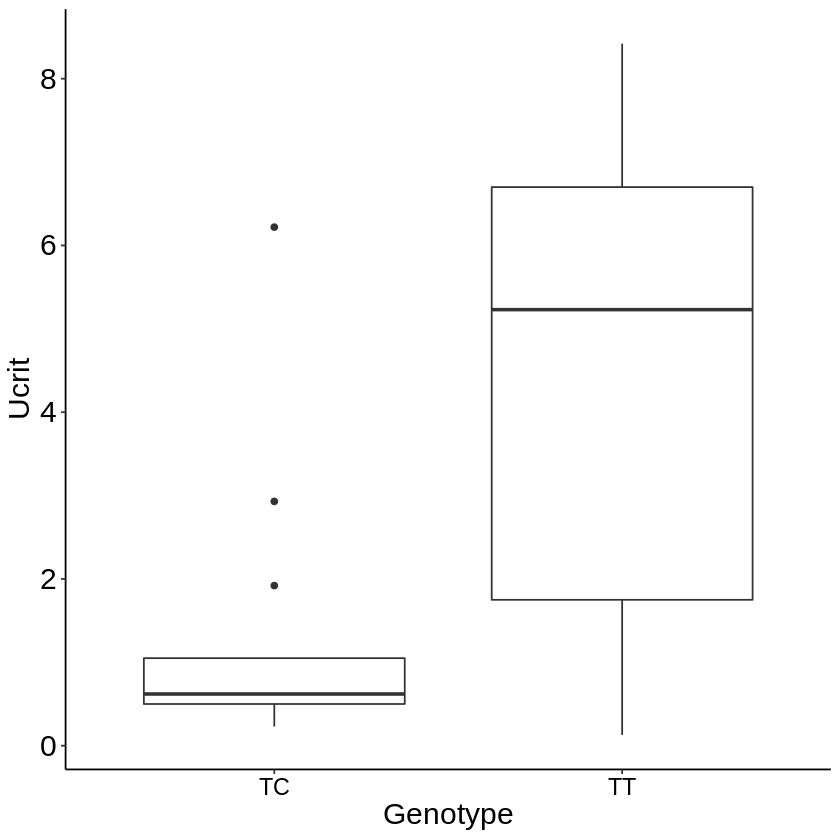

In [247]:
ucrit_plot
ggsave(ucrit_plot, file="/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_genotypes.pdf")

In [196]:
tail(genos)

marker,allele1,allele2,Ind0,Ind0.1,Ind0.2,Ind1,Ind1.1,Ind1.2,Ind2,...,Ind155,Ind156,Ind156.1,Ind156.2,Ind157,Ind157.1,Ind157.2,Ind158,Ind158.1,Ind158.2
10_31930973,0,2,0.688254,0.282714,0.029033,0.688254,0.282714,0.029033,0.688254,...,0.029033,0.688254,0.282714,0.029033,0.688254,0.282714,0.029033,0.688254,0.282714,0.029033
10_31931015,1,2,0.739721,0.240699,0.019580,0.739721,0.240699,0.019580,0.739721,...,0.019580,0.739721,0.240699,0.019580,0.739721,0.240699,0.019580,0.739721,0.240699,0.019580
10_31931089,0,2,0.515885,0.404733,0.079382,0.515885,0.404733,0.079382,0.515885,...,0.079382,0.515885,0.404733,0.079382,0.718238,0.281740,0.000022,0.515885,0.404733,0.079382
10_31931309,1,0,0.299277,0.495570,0.205153,0.299277,0.495570,0.205153,0.299277,...,0.205153,0.299277,0.495570,0.205153,0.299277,0.495570,0.205153,0.299277,0.495570,0.205153
10_31931317,3,1,0.261782,0.499729,0.238490,0.261782,0.499729,0.238490,0.261782,...,0.238490,0.261782,0.499729,0.238490,0.261782,0.499729,0.238490,0.261782,0.499729,0.238490
10_31931339,2,0,0.338481,0.486620,0.174898,0.338481,0.486620,0.174898,0.338481,...,0.174898,0.338481,0.486620,0.174898,0.338481,0.486620,0.174898,0.338481,0.486620,0.174898


In [ ]:
Proportion of variance in phenotype explained by a given SNP (PVE) = [2*(beta^2)*MAF*(1-MAF)]/[2*(beta^2)*MAF(1-MAF)+((se(beta))^2)*2*N*MAF*(1-MAF)]
where:
N - sample size
se(beta) - standard error of effect size for the genetic variant of interest
beta - effect size for the genetic variant of interest
MAF - minor allele frequency for the genetic variant of interest
it is described in:
Shim, H., Chasman, D.I., Smith, J.D., Mora, S., Ridker, P.M., Nickerson, D.A., Krauss, R.M., and Stephens, M. (2015). A multivariate genome-wide association analysis of 10 LDL subfractions, and their response to statin treatment, in 1868 Caucasians. PLoS One 10, e0120758.
Supplementary Information: S1: Computing proportion of variance in phenotype explained by a given SNP (PVE).